# MIScnn: Kidney Tumor Segmentation Challenge 2019

We want to perform a 3-fold cross-validation for kidney tumor segmentation on the Kidney Tumor Segmentation Challenge 2019 (KITS19) data set. To archieve this, we are using our newly developed framework for medical image segmentation. MIScnn: A Framework for Medical Image Segmentation with Convolutional Neural Networks and Deep Learning.

The aim of MIScnn is to provide an intuitive API allowing fast building of medical
image segmentation pipelines including data I/O, preprocessing, data augmentation, patch-wise analysis, metrics, a library with state-of-the-art
deep learning models and model utilization like training, prediction as well as fully automatic evaluation (e.g. cross-validation).
Even so, high configurability and multiple open interfaces allow full pipeline customization. MIScnn is based on Keras with Tensorflow as backend.

More information about MIScnn can be found in the publication or on the Git repository: https://github.com/frankkramer-lab/MIScnn

The task of the KITS19 challenge was to compute a semantic segmentation of arterial phase abdominal CT scans from 300 kidney cancer patients. Each pixel had to be labeled into one of three classes: Background, kidney or tumor. The original scans have an image resolution of 512x512 and on average 216 slices (highest slice number is 1059).

The data for the KITS19 challenge can be found here: https://github.com/neheller/kits19

## Tensorflow Configurations

Before using the MIScnn pipeline, we throttle the Tensorflow Memory hunger by using the RAM growth option.  
This result into a dyanmic growth of required RAM instead of allocating all available RAM without even using it.

Also, we are specify on which GPU Tensorflow should be executed.  
Obviously, we can skip this paragraph if don't need to share you GPUs with other people ;)

In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Create a Data I/O class for the KITS19 files

The first step in the MIScnn pipeline is to establish a Data I/O. MIScnn offers the utilization of custom Data I/O interfaces for fast integration of your specific data structure into the pipeline.   
The KITS19 CT scans are encoded in NIfTI format, therefore we are going to deploy a Data I/O class with the NIfTI interface for handling the NIfTI format.

In [2]:
# Library import
from miscnn.data_loading.interfaces.nifti_io \
     import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO

# Initialize the NIfTI I/O interface and configure the images as one channel (grayscale) and three segmentation classes (background, kidney, tumor)
interface = NIFTI_interface(pattern="case_00[0-9]*", 
                            channels=1, classes=3)

# Specify the kits19 data directory
data_path = "/storage/kits19/data/"
# Create the Data I/O object 
data_io = Data_IO(interface, data_path)

Now, let's test how many samples we can access through our Data I/O Interface.  
We are trying to print out all accessible sample ID's.

In [3]:
sample_list = data_io.get_indiceslist()
sample_list.sort()
print("All samples: " + str(sample_list))

All samples: ['case_00000', 'case_00001', 'case_00002', 'case_00003', 'case_00004', 'case_00005', 'case_00006', 'case_00007', 'case_00008', 'case_00009', 'case_00010', 'case_00011', 'case_00012', 'case_00013', 'case_00014', 'case_00015', 'case_00016', 'case_00017', 'case_00018', 'case_00019', 'case_00020', 'case_00021', 'case_00022', 'case_00023', 'case_00024', 'case_00025', 'case_00026', 'case_00027', 'case_00028', 'case_00029', 'case_00030', 'case_00031', 'case_00032', 'case_00033', 'case_00034', 'case_00035', 'case_00036', 'case_00037', 'case_00038', 'case_00039', 'case_00040', 'case_00041', 'case_00042', 'case_00043', 'case_00044', 'case_00045', 'case_00046', 'case_00047', 'case_00048', 'case_00049', 'case_00050', 'case_00051', 'case_00052', 'case_00053', 'case_00054', 'case_00055', 'case_00056', 'case_00057', 'case_00058', 'case_00059', 'case_00060', 'case_00061', 'case_00062', 'case_00063', 'case_00064', 'case_00065', 'case_00066', 'case_00067', 'case_00068', 'case_00069', 'case_

## Create and configure a Data Augmentation class

After the Data I/O Interface initialization, the Data Augmentation class can be configured.  
A Preprocessor object with default parameters automatically initialize a Data Augmentation class with default values, but here we initialize it by hand to illustrate the exact workflow of the MIScnn pipeline.

The parameters for the Data Augmentation configure which augmentation techniques should be applied to the data set.  
In this case, we are using all possible augmentation techniques in order to run extensive data augmentation and avoid overfitting.

In [4]:
# Library import
from miscnn.processing.data_augmentation import Data_Augmentation

# Create and configure the Data Augmentation class
data_aug = Data_Augmentation(cycles=2, scaling=True, rotations=True, elastic_deform=True, mirror=True,
                             brightness=True, contrast=True, gamma=True, gaussian_noise=True)

## Select Subfunctions for the Preprocessing

For the Preprocessor class, we are now going to define which Subfunctions we want to execute on our data set.
Subfunctions are pre- and postprocessing functions which will be applied on the data in order to boost performance.
It is possible to add already provided Subfunctions from MIScnn or implment custom Subfunctions and pass these to the MIScnn pipeline.

Here, we are initializing three state-of-the-art preprocessing methods.  
- **Pixel** Value Normalziation: Pixel values will be normalized through the Z-Score formula.
- **Clipping:** Pixel value ranges will be clipped according to a provided min/max value. This is advisable through the consistency of CT scan pixel value ranges.
- **Resampling:** MRT and CT images can have different voxel spacings (slice thickness). Therefore a normalization of these voxel spacings to a common scale is required. The resampling process lead also to a smaller image size.

At the end, we are adding all Subfunction objects to a list, which will be passed to the Preprocessor class.

In [5]:
# Library imports
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling

# Create a pixel value normalization Subfunction through Z-Score 
sf_normalize = Normalization(mode='z-score')
# Create a clipping Subfunction between -79 and 304
sf_clipping = Clipping(min=-79, max=304)
# Create a resampling Subfunction to voxel spacing 3.22 x 1.62 x 1.62
sf_resample = Resampling((3.22, 1.62, 1.62))

# Assemble Subfunction classes into a list
# Be aware that the Subfunctions will be exectued according to the list order!
subfunctions = [sf_resample, sf_clipping, sf_normalize]

## Create and configure a Preprocessor class

Finally, we can initialize the Preprocessor class. 

Therefore, we are passing our Data I/O Interface, the Data Augmentation object and our list of Subfunctions.  
Additionally, we configure our Preprocessor to create batches on-the-fly (preprare_batches=False) by random cropping patches with size 80x160x160 out of the image.  
Also a batch should contain 2 patches.

After the initialization, we adjust the overlap between patches for prediction to increase prediction accuracy.

In [6]:
# Library import
from miscnn.processing.preprocessor import Preprocessor

# Create and configure the Preprocessor class
pp = Preprocessor(data_io, data_aug=data_aug, batch_size=2, subfunctions=subfunctions, prepare_subfunctions=True, 
                  prepare_batches=False, analysis="patchwise-crop", patch_shape=(80, 160, 160),
                  use_multiprocessing=True)

# Adjust the patch overlap for predictions
pp.patchwise_overlap = (40, 80, 80)

## Create a Neural Network model

Now it's time to initialize our final object: The Neural Network.  

With the Neural Network class, we are able to run training and prediction operations. But before, we have to decide which Neural Network Architecture and Metric we want to use.  
In order to show the simplicity and performance of MIScnn, we stick with the simple 3D U-Net Architecture for our Neural Network without any special tricks or optimizations. For training, we are using the Dice-Crossentropy (sum of soft Dice and categorical crossentropy) as loss, but also passing the soft Dice and the Tversky Loss as additional metrics for performace evaluation.

With the batch_queue_size and number of workers, we are able to specify the parallel prepared batches and the number of threads for multi-process batch generation.

In [7]:
# Library import
from miscnn.neural_network.model import Neural_Network
from miscnn.neural_network.metrics import dice_soft, dice_crossentropy, tversky_loss

# Create the Neural Network model
model = Neural_Network(preprocessor=pp, loss=tversky_loss, metrics=[dice_soft, dice_crossentropy],
                       batch_queue_size=3, workers=3, learninig_rate=0.0001)

## Callbacks

Due to MIScnn is based on Keras, we are able to use the powerful Callback mechanics of Keras.  
With Callback functions, we are able to interfere in the training process. This possibility can be used for simple additional output of visualization of training metrics or for more adjustments of the training parameters during the runtime.

Here, we are using the ReduceLROnPlateau Callback from Keras. This Callback automatically reduce the learning rate if no loss improvement happens in the last 20 epochs.

In [8]:
# Define Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1, mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)
from tensorflow.keras.callbacks import EarlyStopping
cb_es = EarlyStopping(monitor='loss', min_delta=0, patience=150, verbose=1, mode='min')

## Sample List Preprocessing

Now, we are creating a list of sample ID's for running our cross-validation.

At first, we will exclude all samples which were labeled as suspious by the KiTS19 Challenge organizer and Fabian Isensee (Winner of the KiTS19 Challenge).  
By default, all accessible samples are used, but in order to save time, we are just using the first 120 samples (without the samples which were marked as suspious).

In [9]:
# Exclude suspious samples from data set
del sample_list[133]
del sample_list[125]
del sample_list[68]
del sample_list[37]
del sample_list[23]
del sample_list[15]

# Create the validation sample ID list
validation_samples = sample_list[0:120]
# Output validation samples
print("Validation samples: " + str(validation_samples))

Validation samples: ['case_00000', 'case_00001', 'case_00002', 'case_00003', 'case_00004', 'case_00005', 'case_00006', 'case_00007', 'case_00008', 'case_00009', 'case_00010', 'case_00011', 'case_00012', 'case_00013', 'case_00014', 'case_00016', 'case_00017', 'case_00018', 'case_00019', 'case_00020', 'case_00021', 'case_00022', 'case_00024', 'case_00025', 'case_00026', 'case_00027', 'case_00028', 'case_00029', 'case_00030', 'case_00031', 'case_00032', 'case_00033', 'case_00034', 'case_00035', 'case_00036', 'case_00038', 'case_00039', 'case_00040', 'case_00041', 'case_00042', 'case_00043', 'case_00044', 'case_00045', 'case_00046', 'case_00047', 'case_00048', 'case_00049', 'case_00050', 'case_00051', 'case_00052', 'case_00053', 'case_00054', 'case_00055', 'case_00056', 'case_00057', 'case_00058', 'case_00059', 'case_00060', 'case_00061', 'case_00062', 'case_00063', 'case_00064', 'case_00065', 'case_00066', 'case_00067', 'case_00069', 'case_00070', 'case_00071', 'case_00072', 'case_00073',

## Perform a 3-fold Cross-Validation

It's time to run the cross-validation. Yepi!

We are running now the cross_validation function and define the number of k-folds as 3, the number of epochs and iterations as 350 and 150.

For summary, a cross-validation runs the training and prediction process several times on with different combinations of data set parts.  
Therefore, this step takes a lot of time...

In [10]:
# Library import
from miscnn.evaluation.cross_validation import cross_validation
# Run cross-validation function
cross_validation(validation_samples, model, k_fold=3, epochs=1000, iterations=150,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr, cb_es])

Epoch 1/1000
150/150 [==============================] - ETA: 0s - loss: 1.9692 - dice_soft: 0.3436 - dice_crossentropy: 3.4566
Epoch 00001: val_loss improved from inf to 2.07896, saving model to evaluation/fold_0/model.hdf5
150/150 [==============================] - 194s 1s/step - loss: 1.9692 - dice_soft: 0.3436 - dice_crossentropy: 3.4566 - val_loss: 2.0790 - val_dice_soft: 0.3079 - val_dice_crossentropy: 3.1812
Epoch 2/1000
150/150 [==============================] - ETA: 0s - loss: 1.5551 - dice_soft: 0.4816 - dice_crossentropy: 4.2138
Epoch 00002: val_loss improved from 2.07896 to 1.68100, saving model to evaluation/fold_0/model.hdf5
150/150 [==============================] - 195s 1s/step - loss: 1.5551 - dice_soft: 0.4816 - dice_crossentropy: 4.2138 - val_loss: 1.6810 - val_dice_soft: 0.4440 - val_dice_crossentropy: 3.2723
Epoch 3/1000
150/150 [==============================] - ETA: 0s - loss: 1.3973 - dice_soft: 0.5342 - dice_crossentropy: 3.7478
Epoch 00003: val_loss improved fr

Epoch 22/1000
150/150 [==============================] - ETA: 0s - loss: 0.9847 - dice_soft: 0.6718 - dice_crossentropy: 0.6843
Epoch 00022: val_loss did not improve from 1.07915
150/150 [==============================] - 196s 1s/step - loss: 0.9847 - dice_soft: 0.6718 - dice_crossentropy: 0.6843 - val_loss: 1.1285 - val_dice_soft: 0.6479 - val_dice_crossentropy: 0.4963
Epoch 23/1000
150/150 [==============================] - ETA: 0s - loss: 0.9785 - dice_soft: 0.6738 - dice_crossentropy: 0.5959
Epoch 00023: val_loss improved from 1.07915 to 1.06071, saving model to evaluation/fold_0/model.hdf5
150/150 [==============================] - 198s 1s/step - loss: 0.9785 - dice_soft: 0.6738 - dice_crossentropy: 0.5959 - val_loss: 1.0607 - val_dice_soft: 0.6492 - val_dice_crossentropy: 0.4733
Epoch 24/1000
150/150 [==============================] - ETA: 0s - loss: 0.9991 - dice_soft: 0.6670 - dice_crossentropy: 0.5828
Epoch 00024: val_loss improved from 1.06071 to 1.03361, saving model to eval

150/150 [==============================] - ETA: 0s - loss: 0.6571 - dice_soft: 0.7810 - dice_crossentropy: 0.2699
Epoch 00043: val_loss did not improve from 0.78670
150/150 [==============================] - 192s 1s/step - loss: 0.6571 - dice_soft: 0.7810 - dice_crossentropy: 0.2699 - val_loss: 0.8545 - val_dice_soft: 0.7202 - val_dice_crossentropy: 0.3316
Epoch 44/1000
150/150 [==============================] - ETA: 0s - loss: 0.6188 - dice_soft: 0.7937 - dice_crossentropy: 0.2574
Epoch 00044: val_loss did not improve from 0.78670
150/150 [==============================] - 194s 1s/step - loss: 0.6188 - dice_soft: 0.7937 - dice_crossentropy: 0.2574 - val_loss: 1.0108 - val_dice_soft: 0.6750 - val_dice_crossentropy: 0.3785
Epoch 45/1000
150/150 [==============================] - ETA: 0s - loss: 0.5959 - dice_soft: 0.8014 - dice_crossentropy: 0.2426
Epoch 00045: val_loss did not improve from 0.78670
150/150 [==============================] - 190s 1s/step - loss: 0.5959 - dice_soft: 0.801

Epoch 65/1000
150/150 [==============================] - ETA: 0s - loss: 0.5392 - dice_soft: 0.8203 - dice_crossentropy: 0.2157
Epoch 00065: val_loss did not improve from 0.78168
150/150 [==============================] - 196s 1s/step - loss: 0.5392 - dice_soft: 0.8203 - dice_crossentropy: 0.2157 - val_loss: 0.8917 - val_dice_soft: 0.6920 - val_dice_crossentropy: 0.3388
Epoch 66/1000
150/150 [==============================] - ETA: 0s - loss: 0.5394 - dice_soft: 0.8202 - dice_crossentropy: 0.2210
Epoch 00066: val_loss did not improve from 0.78168
150/150 [==============================] - 191s 1s/step - loss: 0.5394 - dice_soft: 0.8202 - dice_crossentropy: 0.2210 - val_loss: 0.9112 - val_dice_soft: 0.7113 - val_dice_crossentropy: 0.3407
Epoch 67/1000
150/150 [==============================] - ETA: 0s - loss: 0.5590 - dice_soft: 0.8137 - dice_crossentropy: 0.2262
Epoch 00067: val_loss did not improve from 0.78168
150/150 [==============================] - 196s 1s/step - loss: 0.5590 - di

Epoch 87/1000
150/150 [==============================] - ETA: 0s - loss: 0.4758 - dice_soft: 0.8414 - dice_crossentropy: 0.1919
Epoch 00087: val_loss did not improve from 0.73201
150/150 [==============================] - 191s 1s/step - loss: 0.4758 - dice_soft: 0.8414 - dice_crossentropy: 0.1919 - val_loss: 0.8117 - val_dice_soft: 0.7370 - val_dice_crossentropy: 0.3375
Epoch 88/1000
150/150 [==============================] - ETA: 0s - loss: 0.4758 - dice_soft: 0.8414 - dice_crossentropy: 0.1925
Epoch 00088: val_loss did not improve from 0.73201
150/150 [==============================] - 191s 1s/step - loss: 0.4758 - dice_soft: 0.8414 - dice_crossentropy: 0.1925 - val_loss: 0.9347 - val_dice_soft: 0.6879 - val_dice_crossentropy: 0.3783
Epoch 89/1000
150/150 [==============================] - ETA: 0s - loss: 0.4628 - dice_soft: 0.8457 - dice_crossentropy: 0.1852
Epoch 00089: val_loss did not improve from 0.73201
150/150 [==============================] - 194s 1s/step - loss: 0.4628 - di

Epoch 109/1000
150/150 [==============================] - ETA: 0s - loss: 0.4154 - dice_soft: 0.8615 - dice_crossentropy: 0.1660
Epoch 00109: val_loss did not improve from 0.67816
150/150 [==============================] - 193s 1s/step - loss: 0.4154 - dice_soft: 0.8615 - dice_crossentropy: 0.1660 - val_loss: 0.7655 - val_dice_soft: 0.7512 - val_dice_crossentropy: 0.2739
Epoch 110/1000
150/150 [==============================] - ETA: 0s - loss: 0.4191 - dice_soft: 0.8603 - dice_crossentropy: 0.1667
Epoch 00110: val_loss did not improve from 0.67816
150/150 [==============================] - 192s 1s/step - loss: 0.4191 - dice_soft: 0.8603 - dice_crossentropy: 0.1667 - val_loss: 0.8087 - val_dice_soft: 0.7109 - val_dice_crossentropy: 0.3165
Epoch 111/1000
150/150 [==============================] - ETA: 0s - loss: 0.4233 - dice_soft: 0.8589 - dice_crossentropy: 0.1694
Epoch 00111: val_loss did not improve from 0.67816
150/150 [==============================] - 192s 1s/step - loss: 0.4233 -

Epoch 131/1000
150/150 [==============================] - ETA: 0s - loss: 0.4310 - dice_soft: 0.8563 - dice_crossentropy: 0.1712
Epoch 00131: val_loss did not improve from 0.67816
150/150 [==============================] - 191s 1s/step - loss: 0.4310 - dice_soft: 0.8563 - dice_crossentropy: 0.1712 - val_loss: 0.8097 - val_dice_soft: 0.7389 - val_dice_crossentropy: 0.2896
Epoch 132/1000
150/150 [==============================] - ETA: 0s - loss: 0.4219 - dice_soft: 0.8594 - dice_crossentropy: 0.1672
Epoch 00132: val_loss did not improve from 0.67816
150/150 [==============================] - 193s 1s/step - loss: 0.4219 - dice_soft: 0.8594 - dice_crossentropy: 0.1672 - val_loss: 0.7984 - val_dice_soft: 0.7489 - val_dice_crossentropy: 0.2910
Epoch 133/1000
150/150 [==============================] - ETA: 0s - loss: 0.4307 - dice_soft: 0.8564 - dice_crossentropy: 0.1702
Epoch 00133: val_loss did not improve from 0.67816
150/150 [==============================] - 192s 1s/step - loss: 0.4307 -

Epoch 153/1000
150/150 [==============================] - ETA: 0s - loss: 0.4456 - dice_soft: 0.8515 - dice_crossentropy: 0.1734
Epoch 00153: val_loss did not improve from 0.67816
150/150 [==============================] - 193s 1s/step - loss: 0.4456 - dice_soft: 0.8515 - dice_crossentropy: 0.1734 - val_loss: 0.8125 - val_dice_soft: 0.7334 - val_dice_crossentropy: 0.3010
Epoch 154/1000
150/150 [==============================] - ETA: 0s - loss: 0.3919 - dice_soft: 0.8694 - dice_crossentropy: 0.1556
Epoch 00154: val_loss did not improve from 0.67816
150/150 [==============================] - 193s 1s/step - loss: 0.3919 - dice_soft: 0.8694 - dice_crossentropy: 0.1556 - val_loss: 0.8098 - val_dice_soft: 0.7345 - val_dice_crossentropy: 0.3172
Epoch 155/1000
150/150 [==============================] - ETA: 0s - loss: 0.3955 - dice_soft: 0.8682 - dice_crossentropy: 0.1570
Epoch 00155: val_loss did not improve from 0.67816
150/150 [==============================] - 194s 1s/step - loss: 0.3955 -

Epoch 175/1000
150/150 [==============================] - ETA: 0s - loss: 0.4449 - dice_soft: 0.8517 - dice_crossentropy: 0.1748
Epoch 00175: val_loss did not improve from 0.64411
150/150 [==============================] - 192s 1s/step - loss: 0.4449 - dice_soft: 0.8517 - dice_crossentropy: 0.1748 - val_loss: 0.6446 - val_dice_soft: 0.7957 - val_dice_crossentropy: 0.2374
Epoch 176/1000
150/150 [==============================] - ETA: 0s - loss: 0.4329 - dice_soft: 0.8557 - dice_crossentropy: 0.1695
Epoch 00176: val_loss did not improve from 0.64411
150/150 [==============================] - 193s 1s/step - loss: 0.4329 - dice_soft: 0.8557 - dice_crossentropy: 0.1695 - val_loss: 0.7626 - val_dice_soft: 0.7189 - val_dice_crossentropy: 0.3324
Epoch 177/1000
150/150 [==============================] - ETA: 0s - loss: 0.4266 - dice_soft: 0.8578 - dice_crossentropy: 0.1685
Epoch 00177: val_loss did not improve from 0.64411
150/150 [==============================] - 195s 1s/step - loss: 0.4266 -

Epoch 197/1000
150/150 [==============================] - ETA: 0s - loss: 0.3856 - dice_soft: 0.8715 - dice_crossentropy: 0.1531
Epoch 00197: val_loss did not improve from 0.64411
150/150 [==============================] - 192s 1s/step - loss: 0.3856 - dice_soft: 0.8715 - dice_crossentropy: 0.1531 - val_loss: 0.8035 - val_dice_soft: 0.7191 - val_dice_crossentropy: 0.3145
Epoch 198/1000
150/150 [==============================] - ETA: 0s - loss: 0.4172 - dice_soft: 0.8609 - dice_crossentropy: 0.1640
Epoch 00198: val_loss did not improve from 0.64411
150/150 [==============================] - 194s 1s/step - loss: 0.4172 - dice_soft: 0.8609 - dice_crossentropy: 0.1640 - val_loss: 0.7924 - val_dice_soft: 0.7529 - val_dice_crossentropy: 0.2874
Epoch 199/1000
150/150 [==============================] - ETA: 0s - loss: 0.3957 - dice_soft: 0.8681 - dice_crossentropy: 0.1567
Epoch 00199: val_loss did not improve from 0.64411
150/150 [==============================] - 195s 1s/step - loss: 0.3957 -

Epoch 219/1000
150/150 [==============================] - ETA: 0s - loss: 0.4096 - dice_soft: 0.8635 - dice_crossentropy: 0.1625
Epoch 00219: val_loss did not improve from 0.64411
150/150 [==============================] - 192s 1s/step - loss: 0.4096 - dice_soft: 0.8635 - dice_crossentropy: 0.1625 - val_loss: 0.7474 - val_dice_soft: 0.7539 - val_dice_crossentropy: 0.2780
Epoch 220/1000
150/150 [==============================] - ETA: 0s - loss: 0.3927 - dice_soft: 0.8691 - dice_crossentropy: 0.1548
Epoch 00220: val_loss did not improve from 0.64411
150/150 [==============================] - 195s 1s/step - loss: 0.3927 - dice_soft: 0.8691 - dice_crossentropy: 0.1548 - val_loss: 0.7775 - val_dice_soft: 0.7352 - val_dice_crossentropy: 0.3137
Epoch 221/1000
150/150 [==============================] - ETA: 0s - loss: 0.3851 - dice_soft: 0.8716 - dice_crossentropy: 0.1529
Epoch 00221: val_loss did not improve from 0.64411
150/150 [==============================] - 191s 1s/step - loss: 0.3851 -

Epoch 241/1000
150/150 [==============================] - ETA: 0s - loss: 0.3920 - dice_soft: 0.8693 - dice_crossentropy: 0.1555
Epoch 00241: val_loss did not improve from 0.64411
150/150 [==============================] - 191s 1s/step - loss: 0.3920 - dice_soft: 0.8693 - dice_crossentropy: 0.1555 - val_loss: 0.7402 - val_dice_soft: 0.7476 - val_dice_crossentropy: 0.2888
Epoch 242/1000
150/150 [==============================] - ETA: 0s - loss: 0.4162 - dice_soft: 0.8613 - dice_crossentropy: 0.1638
Epoch 00242: val_loss did not improve from 0.64411
150/150 [==============================] - 191s 1s/step - loss: 0.4162 - dice_soft: 0.8613 - dice_crossentropy: 0.1638 - val_loss: 0.8126 - val_dice_soft: 0.7341 - val_dice_crossentropy: 0.2998
Epoch 243/1000
150/150 [==============================] - ETA: 0s - loss: 0.4061 - dice_soft: 0.8646 - dice_crossentropy: 0.1615
Epoch 00243: val_loss did not improve from 0.64411
150/150 [==============================] - 193s 1s/step - loss: 0.4061 -

Epoch 263/1000
150/150 [==============================] - ETA: 0s - loss: 0.3778 - dice_soft: 0.8741 - dice_crossentropy: 0.1503
Epoch 00263: val_loss did not improve from 0.64296
150/150 [==============================] - 190s 1s/step - loss: 0.3778 - dice_soft: 0.8741 - dice_crossentropy: 0.1503 - val_loss: 0.8189 - val_dice_soft: 0.7207 - val_dice_crossentropy: 0.3045
Epoch 264/1000
150/150 [==============================] - ETA: 0s - loss: 0.3864 - dice_soft: 0.8712 - dice_crossentropy: 0.1533
Epoch 00264: val_loss did not improve from 0.64296
150/150 [==============================] - 190s 1s/step - loss: 0.3864 - dice_soft: 0.8712 - dice_crossentropy: 0.1533 - val_loss: 0.8013 - val_dice_soft: 0.7219 - val_dice_crossentropy: 0.3172
Epoch 265/1000
150/150 [==============================] - ETA: 0s - loss: 0.4140 - dice_soft: 0.8620 - dice_crossentropy: 0.1618
Epoch 00265: val_loss did not improve from 0.64296
150/150 [==============================] - 191s 1s/step - loss: 0.4140 -

Epoch 285/1000
150/150 [==============================] - ETA: 0s - loss: 0.3829 - dice_soft: 0.8724 - dice_crossentropy: 0.1517
Epoch 00285: val_loss did not improve from 0.63275
150/150 [==============================] - 194s 1s/step - loss: 0.3829 - dice_soft: 0.8724 - dice_crossentropy: 0.1517 - val_loss: 0.6580 - val_dice_soft: 0.7805 - val_dice_crossentropy: 0.2542
Epoch 286/1000
150/150 [==============================] - ETA: 0s - loss: 0.3917 - dice_soft: 0.8694 - dice_crossentropy: 0.1556
Epoch 00286: val_loss did not improve from 0.63275
150/150 [==============================] - 192s 1s/step - loss: 0.3917 - dice_soft: 0.8694 - dice_crossentropy: 0.1556 - val_loss: 0.7326 - val_dice_soft: 0.7512 - val_dice_crossentropy: 0.2812
Epoch 287/1000
150/150 [==============================] - ETA: 0s - loss: 0.4105 - dice_soft: 0.8632 - dice_crossentropy: 0.1605
Epoch 00287: val_loss did not improve from 0.63275
150/150 [==============================] - 191s 1s/step - loss: 0.4105 -

Epoch 307/1000
150/150 [==============================] - ETA: 0s - loss: 0.3991 - dice_soft: 0.8670 - dice_crossentropy: 0.1575
Epoch 00307: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3991 - dice_soft: 0.8670 - dice_crossentropy: 0.1575 - val_loss: 0.6841 - val_dice_soft: 0.7830 - val_dice_crossentropy: 0.2536
Epoch 308/1000
150/150 [==============================] - ETA: 0s - loss: 0.3618 - dice_soft: 0.8794 - dice_crossentropy: 0.1447
Epoch 00308: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3618 - dice_soft: 0.8794 - dice_crossentropy: 0.1447 - val_loss: 0.7010 - val_dice_soft: 0.7743 - val_dice_crossentropy: 0.2605
Epoch 309/1000
150/150 [==============================] - ETA: 0s - loss: 0.3945 - dice_soft: 0.8685 - dice_crossentropy: 0.1562
Epoch 00309: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3945 -

Epoch 329/1000
150/150 [==============================] - ETA: 0s - loss: 0.3707 - dice_soft: 0.8764 - dice_crossentropy: 0.1494
Epoch 00329: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.3707 - dice_soft: 0.8764 - dice_crossentropy: 0.1494 - val_loss: 0.8248 - val_dice_soft: 0.7239 - val_dice_crossentropy: 0.3099
Epoch 330/1000
150/150 [==============================] - ETA: 0s - loss: 0.3516 - dice_soft: 0.8828 - dice_crossentropy: 0.1418
Epoch 00330: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3516 - dice_soft: 0.8828 - dice_crossentropy: 0.1418 - val_loss: 0.7671 - val_dice_soft: 0.7549 - val_dice_crossentropy: 0.2800
Epoch 331/1000
150/150 [==============================] - ETA: 0s - loss: 0.4263 - dice_soft: 0.8579 - dice_crossentropy: 0.1669
Epoch 00331: val_loss did not improve from 0.55378
150/150 [==============================] - 190s 1s/step - loss: 0.4263 -

Epoch 351/1000
150/150 [==============================] - ETA: 0s - loss: 0.3927 - dice_soft: 0.8691 - dice_crossentropy: 0.1541
Epoch 00351: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3927 - dice_soft: 0.8691 - dice_crossentropy: 0.1541 - val_loss: 0.7346 - val_dice_soft: 0.7603 - val_dice_crossentropy: 0.2842
Epoch 352/1000
150/150 [==============================] - ETA: 0s - loss: 0.3807 - dice_soft: 0.8731 - dice_crossentropy: 0.1515
Epoch 00352: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3807 - dice_soft: 0.8731 - dice_crossentropy: 0.1515 - val_loss: 0.8368 - val_dice_soft: 0.7234 - val_dice_crossentropy: 0.3230
Epoch 353/1000
150/150 [==============================] - ETA: 0s - loss: 0.4236 - dice_soft: 0.8588 - dice_crossentropy: 0.1645
Epoch 00353: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.4236 -

Epoch 373/1000
150/150 [==============================] - ETA: 0s - loss: 0.3747 - dice_soft: 0.8751 - dice_crossentropy: 0.1482
Epoch 00373: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3747 - dice_soft: 0.8751 - dice_crossentropy: 0.1482 - val_loss: 0.8363 - val_dice_soft: 0.7151 - val_dice_crossentropy: 0.3226
Epoch 374/1000
150/150 [==============================] - ETA: 0s - loss: 0.3715 - dice_soft: 0.8762 - dice_crossentropy: 0.1490
Epoch 00374: val_loss did not improve from 0.55378
150/150 [==============================] - 190s 1s/step - loss: 0.3715 - dice_soft: 0.8762 - dice_crossentropy: 0.1490 - val_loss: 0.7827 - val_dice_soft: 0.7267 - val_dice_crossentropy: 0.3131
Epoch 375/1000
150/150 [==============================] - ETA: 0s - loss: 0.4077 - dice_soft: 0.8641 - dice_crossentropy: 0.1584
Epoch 00375: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.4077 -

Epoch 395/1000
150/150 [==============================] - ETA: 0s - loss: 0.3926 - dice_soft: 0.8691 - dice_crossentropy: 0.1551
Epoch 00395: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3926 - dice_soft: 0.8691 - dice_crossentropy: 0.1551 - val_loss: 0.7501 - val_dice_soft: 0.7583 - val_dice_crossentropy: 0.2740
Epoch 396/1000
150/150 [==============================] - ETA: 0s - loss: 0.3971 - dice_soft: 0.8676 - dice_crossentropy: 0.1569
Epoch 00396: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3971 - dice_soft: 0.8676 - dice_crossentropy: 0.1569 - val_loss: 0.7581 - val_dice_soft: 0.7554 - val_dice_crossentropy: 0.2831
Epoch 397/1000
150/150 [==============================] - ETA: 0s - loss: 0.3732 - dice_soft: 0.8756 - dice_crossentropy: 0.1486
Epoch 00397: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.3732 -

Epoch 417/1000
150/150 [==============================] - ETA: 0s - loss: 0.3424 - dice_soft: 0.8859 - dice_crossentropy: 0.1380
Epoch 00417: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3424 - dice_soft: 0.8859 - dice_crossentropy: 0.1380 - val_loss: 0.7712 - val_dice_soft: 0.7424 - val_dice_crossentropy: 0.2992
Epoch 418/1000
150/150 [==============================] - ETA: 0s - loss: 0.3958 - dice_soft: 0.8681 - dice_crossentropy: 0.1559
Epoch 00418: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3958 - dice_soft: 0.8681 - dice_crossentropy: 0.1559 - val_loss: 0.7903 - val_dice_soft: 0.7478 - val_dice_crossentropy: 0.2857
Epoch 419/1000
150/150 [==============================] - ETA: 0s - loss: 0.3840 - dice_soft: 0.8720 - dice_crossentropy: 0.1527
Epoch 00419: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.3840 -

Epoch 439/1000
150/150 [==============================] - ETA: 0s - loss: 0.3997 - dice_soft: 0.8668 - dice_crossentropy: 0.1561
Epoch 00439: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3997 - dice_soft: 0.8668 - dice_crossentropy: 0.1561 - val_loss: 0.7856 - val_dice_soft: 0.7404 - val_dice_crossentropy: 0.2963
Epoch 440/1000
150/150 [==============================] - ETA: 0s - loss: 0.3870 - dice_soft: 0.8710 - dice_crossentropy: 0.1525
Epoch 00440: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3870 - dice_soft: 0.8710 - dice_crossentropy: 0.1525 - val_loss: 0.8067 - val_dice_soft: 0.7247 - val_dice_crossentropy: 0.3134
Epoch 441/1000
150/150 [==============================] - ETA: 0s - loss: 0.4173 - dice_soft: 0.8609 - dice_crossentropy: 0.1624
Epoch 00441: val_loss did not improve from 0.55378
150/150 [==============================] - 194s 1s/step - loss: 0.4173 -

Epoch 461/1000
150/150 [==============================] - ETA: 0s - loss: 0.4150 - dice_soft: 0.8617 - dice_crossentropy: 0.1611
Epoch 00461: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.4150 - dice_soft: 0.8617 - dice_crossentropy: 0.1611 - val_loss: 0.7043 - val_dice_soft: 0.7753 - val_dice_crossentropy: 0.2607
Epoch 462/1000
150/150 [==============================] - ETA: 0s - loss: 0.3537 - dice_soft: 0.8821 - dice_crossentropy: 0.1421
Epoch 00462: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3537 - dice_soft: 0.8821 - dice_crossentropy: 0.1421 - val_loss: 0.7523 - val_dice_soft: 0.7247 - val_dice_crossentropy: 0.3176
Epoch 463/1000
150/150 [==============================] - ETA: 0s - loss: 0.3661 - dice_soft: 0.8780 - dice_crossentropy: 0.1458
Epoch 00463: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3661 -

Epoch 483/1000
150/150 [==============================] - ETA: 0s - loss: 0.3952 - dice_soft: 0.8683 - dice_crossentropy: 0.1543
Epoch 00483: val_loss did not improve from 0.55378
150/150 [==============================] - 194s 1s/step - loss: 0.3952 - dice_soft: 0.8683 - dice_crossentropy: 0.1543 - val_loss: 0.8701 - val_dice_soft: 0.6949 - val_dice_crossentropy: 0.3455
Epoch 484/1000
150/150 [==============================] - ETA: 0s - loss: 0.3854 - dice_soft: 0.8716 - dice_crossentropy: 0.1507
Epoch 00484: val_loss did not improve from 0.55378
150/150 [==============================] - 194s 1s/step - loss: 0.3854 - dice_soft: 0.8716 - dice_crossentropy: 0.1507 - val_loss: 0.6883 - val_dice_soft: 0.7663 - val_dice_crossentropy: 0.2808
Epoch 485/1000
150/150 [==============================] - ETA: 0s - loss: 0.3397 - dice_soft: 0.8868 - dice_crossentropy: 0.1362
Epoch 00485: val_loss did not improve from 0.55378
150/150 [==============================] - 194s 1s/step - loss: 0.3397 -

Epoch 505/1000
150/150 [==============================] - ETA: 0s - loss: 0.3531 - dice_soft: 0.8823 - dice_crossentropy: 0.1413
Epoch 00505: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.3531 - dice_soft: 0.8823 - dice_crossentropy: 0.1413 - val_loss: 0.7266 - val_dice_soft: 0.7637 - val_dice_crossentropy: 0.2631
Epoch 506/1000
150/150 [==============================] - ETA: 0s - loss: 0.3628 - dice_soft: 0.8791 - dice_crossentropy: 0.1444
Epoch 00506: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.3628 - dice_soft: 0.8791 - dice_crossentropy: 0.1444 - val_loss: 0.6243 - val_dice_soft: 0.7794 - val_dice_crossentropy: 0.2504
Epoch 507/1000
150/150 [==============================] - ETA: 0s - loss: 0.3975 - dice_soft: 0.8675 - dice_crossentropy: 0.1547
Epoch 00507: val_loss did not improve from 0.55378
150/150 [==============================] - 191s 1s/step - loss: 0.3975 -

Epoch 527/1000
150/150 [==============================] - ETA: 0s - loss: 0.3615 - dice_soft: 0.8795 - dice_crossentropy: 0.1436
Epoch 00527: val_loss did not improve from 0.55378
150/150 [==============================] - 193s 1s/step - loss: 0.3615 - dice_soft: 0.8795 - dice_crossentropy: 0.1436 - val_loss: 0.6840 - val_dice_soft: 0.7688 - val_dice_crossentropy: 0.2839
Epoch 528/1000
150/150 [==============================] - ETA: 0s - loss: 0.4148 - dice_soft: 0.8617 - dice_crossentropy: 0.1608
Epoch 00528: val_loss did not improve from 0.55378
150/150 [==============================] - 196s 1s/step - loss: 0.4148 - dice_soft: 0.8617 - dice_crossentropy: 0.1608 - val_loss: 0.6202 - val_dice_soft: 0.7943 - val_dice_crossentropy: 0.2396
Epoch 529/1000
150/150 [==============================] - ETA: 0s - loss: 0.3817 - dice_soft: 0.8728 - dice_crossentropy: 0.1500
Epoch 00529: val_loss did not improve from 0.55378
150/150 [==============================] - 192s 1s/step - loss: 0.3817 -

Epoch 10/1000
150/150 [==============================] - ETA: 0s - loss: 1.5629 - dice_soft: 0.4790 - dice_crossentropy: 4.7684
Epoch 00010: val_loss improved from 1.58594 to 1.51950, saving model to evaluation/fold_1/model.hdf5
150/150 [==============================] - 194s 1s/step - loss: 1.5629 - dice_soft: 0.4790 - dice_crossentropy: 4.7684 - val_loss: 1.5195 - val_dice_soft: 0.4905 - val_dice_crossentropy: 4.4292
Epoch 11/1000
150/150 [==============================] - ETA: 0s - loss: 1.5140 - dice_soft: 0.4953 - dice_crossentropy: 4.8262
Epoch 00011: val_loss did not improve from 1.51950
150/150 [==============================] - 193s 1s/step - loss: 1.5140 - dice_soft: 0.4953 - dice_crossentropy: 4.8262 - val_loss: 1.5519 - val_dice_soft: 0.4767 - val_dice_crossentropy: 4.5916
Epoch 12/1000
150/150 [==============================] - ETA: 0s - loss: 1.5279 - dice_soft: 0.4907 - dice_crossentropy: 4.8742
Epoch 00012: val_loss improved from 1.51950 to 1.50413, saving model to eval

Epoch 31/1000
150/150 [==============================] - ETA: 0s - loss: 1.3229 - dice_soft: 0.5590 - dice_crossentropy: 3.6823
Epoch 00031: val_loss improved from 1.32632 to 1.30462, saving model to evaluation/fold_1/model.hdf5
150/150 [==============================] - 195s 1s/step - loss: 1.3229 - dice_soft: 0.5590 - dice_crossentropy: 3.6823 - val_loss: 1.3046 - val_dice_soft: 0.5631 - val_dice_crossentropy: 3.5051
Epoch 32/1000
150/150 [==============================] - ETA: 0s - loss: 1.3226 - dice_soft: 0.5591 - dice_crossentropy: 3.6678
Epoch 00032: val_loss did not improve from 1.30462
150/150 [==============================] - 194s 1s/step - loss: 1.3226 - dice_soft: 0.5591 - dice_crossentropy: 3.6678 - val_loss: 1.3635 - val_dice_soft: 0.5458 - val_dice_crossentropy: 3.4689
Epoch 33/1000
150/150 [==============================] - ETA: 0s - loss: 1.3140 - dice_soft: 0.5620 - dice_crossentropy: 3.5534
Epoch 00033: val_loss did not improve from 1.30462
150/150 [================

Epoch 53/1000
150/150 [==============================] - ETA: 0s - loss: 1.2153 - dice_soft: 0.5949 - dice_crossentropy: 2.6731
Epoch 00053: val_loss did not improve from 1.18822
150/150 [==============================] - 194s 1s/step - loss: 1.2153 - dice_soft: 0.5949 - dice_crossentropy: 2.6731 - val_loss: 1.2571 - val_dice_soft: 0.5762 - val_dice_crossentropy: 2.3563
Epoch 54/1000
150/150 [==============================] - ETA: 0s - loss: 1.2283 - dice_soft: 0.5906 - dice_crossentropy: 2.6661
Epoch 00054: val_loss did not improve from 1.18822
150/150 [==============================] - 192s 1s/step - loss: 1.2283 - dice_soft: 0.5906 - dice_crossentropy: 2.6661 - val_loss: 1.2497 - val_dice_soft: 0.5843 - val_dice_crossentropy: 2.3336
Epoch 55/1000
150/150 [==============================] - ETA: 0s - loss: 1.1956 - dice_soft: 0.6015 - dice_crossentropy: 2.5871
Epoch 00055: val_loss improved from 1.18822 to 1.16736, saving model to evaluation/fold_1/model.hdf5
150/150 [================

Epoch 75/1000
150/150 [==============================] - ETA: 0s - loss: 1.1468 - dice_soft: 0.6177 - dice_crossentropy: 2.0981
Epoch 00075: val_loss did not improve from 0.96795
150/150 [==============================] - 197s 1s/step - loss: 1.1468 - dice_soft: 0.6177 - dice_crossentropy: 2.0981 - val_loss: 1.2309 - val_dice_soft: 0.5910 - val_dice_crossentropy: 2.2931
Epoch 76/1000
150/150 [==============================] - ETA: 0s - loss: 1.1183 - dice_soft: 0.6272 - dice_crossentropy: 1.9895
Epoch 00076: val_loss did not improve from 0.96795
150/150 [==============================] - 194s 1s/step - loss: 1.1183 - dice_soft: 0.6272 - dice_crossentropy: 1.9895 - val_loss: 1.0662 - val_dice_soft: 0.6452 - val_dice_crossentropy: 2.0013
Epoch 77/1000
150/150 [==============================] - ETA: 0s - loss: 1.1204 - dice_soft: 0.6265 - dice_crossentropy: 2.0485
Epoch 00077: val_loss did not improve from 0.96795
150/150 [==============================] - 196s 1s/step - loss: 1.1204 - di

Epoch 97/1000
150/150 [==============================] - ETA: 0s - loss: 1.0290 - dice_soft: 0.6570 - dice_crossentropy: 1.6957
Epoch 00097: val_loss did not improve from 0.96795
150/150 [==============================] - 196s 1s/step - loss: 1.0290 - dice_soft: 0.6570 - dice_crossentropy: 1.6957 - val_loss: 1.1458 - val_dice_soft: 0.6251 - val_dice_crossentropy: 1.6487
Epoch 98/1000
150/150 [==============================] - ETA: 0s - loss: 1.0380 - dice_soft: 0.6540 - dice_crossentropy: 1.6939
Epoch 00098: val_loss did not improve from 0.96795
150/150 [==============================] - 194s 1s/step - loss: 1.0380 - dice_soft: 0.6540 - dice_crossentropy: 1.6939 - val_loss: 1.0941 - val_dice_soft: 0.6452 - val_dice_crossentropy: 1.6410
Epoch 99/1000
150/150 [==============================] - ETA: 0s - loss: 1.0163 - dice_soft: 0.6612 - dice_crossentropy: 1.7505
Epoch 00099: val_loss did not improve from 0.96795
150/150 [==============================] - 193s 1s/step - loss: 1.0163 - di

Epoch 119/1000
150/150 [==============================] - ETA: 0s - loss: 0.9615 - dice_soft: 0.6795 - dice_crossentropy: 1.3211
Epoch 00119: val_loss did not improve from 0.96795
150/150 [==============================] - 193s 1s/step - loss: 0.9615 - dice_soft: 0.6795 - dice_crossentropy: 1.3211 - val_loss: 1.1297 - val_dice_soft: 0.6225 - val_dice_crossentropy: 2.3627
Epoch 120/1000
150/150 [==============================] - ETA: 0s - loss: 1.0065 - dice_soft: 0.6645 - dice_crossentropy: 1.4585
Epoch 00120: val_loss did not improve from 0.96795
150/150 [==============================] - 194s 1s/step - loss: 1.0065 - dice_soft: 0.6645 - dice_crossentropy: 1.4585 - val_loss: 1.0972 - val_dice_soft: 0.6460 - val_dice_crossentropy: 2.0141
Epoch 121/1000
150/150 [==============================] - ETA: 0s - loss: 0.9500 - dice_soft: 0.6833 - dice_crossentropy: 1.3829
Epoch 00121: val_loss did not improve from 0.96795
150/150 [==============================] - 195s 1s/step - loss: 0.9500 -

Epoch 141/1000
150/150 [==============================] - ETA: 0s - loss: 0.9394 - dice_soft: 0.6869 - dice_crossentropy: 1.1615
Epoch 00141: val_loss did not improve from 0.94155
150/150 [==============================] - 192s 1s/step - loss: 0.9394 - dice_soft: 0.6869 - dice_crossentropy: 1.1615 - val_loss: 1.1287 - val_dice_soft: 0.6342 - val_dice_crossentropy: 2.2331
Epoch 142/1000
150/150 [==============================] - ETA: 0s - loss: 0.9497 - dice_soft: 0.6834 - dice_crossentropy: 1.0875
Epoch 00142: val_loss did not improve from 0.94155
150/150 [==============================] - 192s 1s/step - loss: 0.9497 - dice_soft: 0.6834 - dice_crossentropy: 1.0875 - val_loss: 0.9706 - val_dice_soft: 0.6693 - val_dice_crossentropy: 1.1908
Epoch 143/1000
150/150 [==============================] - ETA: 0s - loss: 0.9216 - dice_soft: 0.6928 - dice_crossentropy: 1.0912
Epoch 00143: val_loss did not improve from 0.94155
150/150 [==============================] - 193s 1s/step - loss: 0.9216 -

Epoch 163/1000
150/150 [==============================] - ETA: 0s - loss: 0.8833 - dice_soft: 0.7056 - dice_crossentropy: 0.9329
Epoch 00163: val_loss did not improve from 0.84549
150/150 [==============================] - 194s 1s/step - loss: 0.8833 - dice_soft: 0.7056 - dice_crossentropy: 0.9329 - val_loss: 1.3005 - val_dice_soft: 0.5653 - val_dice_crossentropy: 2.7075
Epoch 164/1000
150/150 [==============================] - ETA: 0s - loss: 0.8495 - dice_soft: 0.7168 - dice_crossentropy: 0.9696
Epoch 00164: val_loss did not improve from 0.84549
150/150 [==============================] - 194s 1s/step - loss: 0.8495 - dice_soft: 0.7168 - dice_crossentropy: 0.9696 - val_loss: 1.0531 - val_dice_soft: 0.6395 - val_dice_crossentropy: 1.6728
Epoch 165/1000
150/150 [==============================] - ETA: 0s - loss: 0.8559 - dice_soft: 0.7147 - dice_crossentropy: 0.9543
Epoch 00165: val_loss did not improve from 0.84549
150/150 [==============================] - 193s 1s/step - loss: 0.8559 -

Epoch 185/1000
150/150 [==============================] - ETA: 0s - loss: 0.8389 - dice_soft: 0.7204 - dice_crossentropy: 0.7924
Epoch 00185: val_loss did not improve from 0.84549
150/150 [==============================] - 192s 1s/step - loss: 0.8389 - dice_soft: 0.7204 - dice_crossentropy: 0.7924 - val_loss: 0.9938 - val_dice_soft: 0.6684 - val_dice_crossentropy: 2.4719
Epoch 186/1000
150/150 [==============================] - ETA: 0s - loss: 0.8555 - dice_soft: 0.7148 - dice_crossentropy: 0.8276
Epoch 00186: val_loss did not improve from 0.84549
150/150 [==============================] - 194s 1s/step - loss: 0.8555 - dice_soft: 0.7148 - dice_crossentropy: 0.8276 - val_loss: 1.0771 - val_dice_soft: 0.6194 - val_dice_crossentropy: 2.2022
Epoch 187/1000
150/150 [==============================] - ETA: 0s - loss: 0.8455 - dice_soft: 0.7182 - dice_crossentropy: 0.7638
Epoch 00187: val_loss did not improve from 0.84549
150/150 [==============================] - 193s 1s/step - loss: 0.8455 -

Epoch 207/1000
150/150 [==============================] - ETA: 0s - loss: 0.8261 - dice_soft: 0.7246 - dice_crossentropy: 0.6986
Epoch 00207: val_loss did not improve from 0.84549
150/150 [==============================] - 192s 1s/step - loss: 0.8261 - dice_soft: 0.7246 - dice_crossentropy: 0.6986 - val_loss: 0.9341 - val_dice_soft: 0.6527 - val_dice_crossentropy: 2.0952
Epoch 208/1000
150/150 [==============================] - ETA: 0s - loss: 0.8082 - dice_soft: 0.7306 - dice_crossentropy: 0.5757
Epoch 00208: val_loss did not improve from 0.84549
150/150 [==============================] - 194s 1s/step - loss: 0.8082 - dice_soft: 0.7306 - dice_crossentropy: 0.5757 - val_loss: 1.0424 - val_dice_soft: 0.6608 - val_dice_crossentropy: 1.3564
Epoch 209/1000
150/150 [==============================] - ETA: 0s - loss: 0.8093 - dice_soft: 0.7302 - dice_crossentropy: 0.6403
Epoch 00209: val_loss did not improve from 0.84549
150/150 [==============================] - 194s 1s/step - loss: 0.8093 -

Epoch 229/1000
150/150 [==============================] - ETA: 0s - loss: 0.7998 - dice_soft: 0.7334 - dice_crossentropy: 0.4862
Epoch 00229: val_loss did not improve from 0.84549
150/150 [==============================] - 193s 1s/step - loss: 0.7998 - dice_soft: 0.7334 - dice_crossentropy: 0.4862 - val_loss: 0.9686 - val_dice_soft: 0.6668 - val_dice_crossentropy: 1.6010
Epoch 230/1000
150/150 [==============================] - ETA: 0s - loss: 0.7895 - dice_soft: 0.7368 - dice_crossentropy: 0.4839
Epoch 00230: val_loss did not improve from 0.84549
150/150 [==============================] - 196s 1s/step - loss: 0.7895 - dice_soft: 0.7368 - dice_crossentropy: 0.4839 - val_loss: 1.1080 - val_dice_soft: 0.6620 - val_dice_crossentropy: 1.7250
Epoch 231/1000
150/150 [==============================] - ETA: 0s - loss: 0.7816 - dice_soft: 0.7395 - dice_crossentropy: 0.4891
Epoch 00231: val_loss did not improve from 0.84549
150/150 [==============================] - 193s 1s/step - loss: 0.7816 -

Epoch 251/1000
150/150 [==============================] - ETA: 0s - loss: 0.6237 - dice_soft: 0.7921 - dice_crossentropy: 0.2530
Epoch 00251: val_loss did not improve from 0.79746
150/150 [==============================] - 195s 1s/step - loss: 0.6237 - dice_soft: 0.7921 - dice_crossentropy: 0.2530 - val_loss: 0.9027 - val_dice_soft: 0.6870 - val_dice_crossentropy: 0.4090
Epoch 252/1000
150/150 [==============================] - ETA: 0s - loss: 0.6959 - dice_soft: 0.7680 - dice_crossentropy: 0.2696
Epoch 00252: val_loss did not improve from 0.79746
150/150 [==============================] - 192s 1s/step - loss: 0.6959 - dice_soft: 0.7680 - dice_crossentropy: 0.2696 - val_loss: 1.0688 - val_dice_soft: 0.6545 - val_dice_crossentropy: 0.4311
Epoch 253/1000
150/150 [==============================] - ETA: 0s - loss: 0.6159 - dice_soft: 0.7947 - dice_crossentropy: 0.2403
Epoch 00253: val_loss did not improve from 0.79746
150/150 [==============================] - 194s 1s/step - loss: 0.6159 -

Epoch 273/1000
150/150 [==============================] - ETA: 0s - loss: 0.5797 - dice_soft: 0.8068 - dice_crossentropy: 0.2340
Epoch 00273: val_loss did not improve from 0.79746
150/150 [==============================] - 194s 1s/step - loss: 0.5797 - dice_soft: 0.8068 - dice_crossentropy: 0.2340 - val_loss: 1.0546 - val_dice_soft: 0.6438 - val_dice_crossentropy: 0.4431
Epoch 274/1000
150/150 [==============================] - ETA: 0s - loss: 0.5921 - dice_soft: 0.8026 - dice_crossentropy: 0.2321
Epoch 00274: val_loss did not improve from 0.79746
150/150 [==============================] - 195s 1s/step - loss: 0.5921 - dice_soft: 0.8026 - dice_crossentropy: 0.2321 - val_loss: 0.8907 - val_dice_soft: 0.7072 - val_dice_crossentropy: 0.3672
Epoch 275/1000
150/150 [==============================] - ETA: 0s - loss: 0.5684 - dice_soft: 0.8105 - dice_crossentropy: 0.2220
Epoch 00275: val_loss did not improve from 0.79746
150/150 [==============================] - 196s 1s/step - loss: 0.5684 -

Epoch 295/1000
150/150 [==============================] - ETA: 0s - loss: 0.5810 - dice_soft: 0.8063 - dice_crossentropy: 0.2280
Epoch 00295: val_loss did not improve from 0.74321
150/150 [==============================] - 196s 1s/step - loss: 0.5810 - dice_soft: 0.8063 - dice_crossentropy: 0.2280 - val_loss: 1.0122 - val_dice_soft: 0.6727 - val_dice_crossentropy: 0.4011
Epoch 296/1000
150/150 [==============================] - ETA: 0s - loss: 0.5640 - dice_soft: 0.8120 - dice_crossentropy: 0.2290
Epoch 00296: val_loss did not improve from 0.74321
150/150 [==============================] - 194s 1s/step - loss: 0.5640 - dice_soft: 0.8120 - dice_crossentropy: 0.2290 - val_loss: 0.9059 - val_dice_soft: 0.6959 - val_dice_crossentropy: 0.3734
Epoch 297/1000
150/150 [==============================] - ETA: 0s - loss: 0.5304 - dice_soft: 0.8232 - dice_crossentropy: 0.2141
Epoch 00297: val_loss did not improve from 0.74321
150/150 [==============================] - 193s 1s/step - loss: 0.5304 -

Epoch 317/1000
150/150 [==============================] - ETA: 0s - loss: 0.5284 - dice_soft: 0.8239 - dice_crossentropy: 0.2066
Epoch 00317: val_loss did not improve from 0.74321
150/150 [==============================] - 195s 1s/step - loss: 0.5284 - dice_soft: 0.8239 - dice_crossentropy: 0.2066 - val_loss: 0.8889 - val_dice_soft: 0.6971 - val_dice_crossentropy: 0.3770
Epoch 318/1000
150/150 [==============================] - ETA: 0s - loss: 0.5017 - dice_soft: 0.8328 - dice_crossentropy: 0.1998
Epoch 00318: val_loss did not improve from 0.74321
150/150 [==============================] - 194s 1s/step - loss: 0.5017 - dice_soft: 0.8328 - dice_crossentropy: 0.1998 - val_loss: 0.9351 - val_dice_soft: 0.7031 - val_dice_crossentropy: 0.3659
Epoch 319/1000
150/150 [==============================] - ETA: 0s - loss: 0.5401 - dice_soft: 0.8200 - dice_crossentropy: 0.2119
Epoch 00319: val_loss improved from 0.74321 to 0.62308, saving model to evaluation/fold_1/model.hdf5
150/150 [=============

Epoch 339/1000
150/150 [==============================] - ETA: 0s - loss: 0.5121 - dice_soft: 0.8293 - dice_crossentropy: 0.2008
Epoch 00339: val_loss did not improve from 0.62308
150/150 [==============================] - 194s 1s/step - loss: 0.5121 - dice_soft: 0.8293 - dice_crossentropy: 0.2008 - val_loss: 0.9184 - val_dice_soft: 0.6960 - val_dice_crossentropy: 0.4083
Epoch 340/1000
150/150 [==============================] - ETA: 0s - loss: 0.5245 - dice_soft: 0.8252 - dice_crossentropy: 0.2037
Epoch 00340: val_loss did not improve from 0.62308
150/150 [==============================] - 194s 1s/step - loss: 0.5245 - dice_soft: 0.8252 - dice_crossentropy: 0.2037 - val_loss: 0.7842 - val_dice_soft: 0.7403 - val_dice_crossentropy: 0.3376
Epoch 341/1000
150/150 [==============================] - ETA: 0s - loss: 0.4904 - dice_soft: 0.8365 - dice_crossentropy: 0.1954
Epoch 00341: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4904 -

Epoch 361/1000
150/150 [==============================] - ETA: 0s - loss: 0.4929 - dice_soft: 0.8357 - dice_crossentropy: 0.1942
Epoch 00361: val_loss did not improve from 0.62308
150/150 [==============================] - 197s 1s/step - loss: 0.4929 - dice_soft: 0.8357 - dice_crossentropy: 0.1942 - val_loss: 0.7924 - val_dice_soft: 0.7193 - val_dice_crossentropy: 0.3606
Epoch 362/1000
150/150 [==============================] - ETA: 0s - loss: 0.4780 - dice_soft: 0.8407 - dice_crossentropy: 0.1890
Epoch 00362: val_loss did not improve from 0.62308
150/150 [==============================] - 192s 1s/step - loss: 0.4780 - dice_soft: 0.8407 - dice_crossentropy: 0.1890 - val_loss: 0.8444 - val_dice_soft: 0.7194 - val_dice_crossentropy: 0.3626
Epoch 363/1000
150/150 [==============================] - ETA: 0s - loss: 0.5125 - dice_soft: 0.8292 - dice_crossentropy: 0.2003
Epoch 00363: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.5125 -

Epoch 383/1000
150/150 [==============================] - ETA: 0s - loss: 0.4956 - dice_soft: 0.8348 - dice_crossentropy: 0.1938
Epoch 00383: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4956 - dice_soft: 0.8348 - dice_crossentropy: 0.1938 - val_loss: 0.8439 - val_dice_soft: 0.7223 - val_dice_crossentropy: 0.3614
Epoch 384/1000
150/150 [==============================] - ETA: 0s - loss: 0.4641 - dice_soft: 0.8453 - dice_crossentropy: 0.1845
Epoch 00384: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4641 - dice_soft: 0.8453 - dice_crossentropy: 0.1845 - val_loss: 0.8039 - val_dice_soft: 0.7355 - val_dice_crossentropy: 0.3474
Epoch 385/1000
150/150 [==============================] - ETA: 0s - loss: 0.4760 - dice_soft: 0.8413 - dice_crossentropy: 0.1883
Epoch 00385: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4760 -

Epoch 405/1000
150/150 [==============================] - ETA: 0s - loss: 0.4533 - dice_soft: 0.8489 - dice_crossentropy: 0.1801
Epoch 00405: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4533 - dice_soft: 0.8489 - dice_crossentropy: 0.1801 - val_loss: 0.8725 - val_dice_soft: 0.6980 - val_dice_crossentropy: 0.3860
Epoch 406/1000
150/150 [==============================] - ETA: 0s - loss: 0.5287 - dice_soft: 0.8238 - dice_crossentropy: 0.2024
Epoch 00406: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.5287 - dice_soft: 0.8238 - dice_crossentropy: 0.2024 - val_loss: 0.7877 - val_dice_soft: 0.7343 - val_dice_crossentropy: 0.3290
Epoch 407/1000
150/150 [==============================] - ETA: 0s - loss: 0.4779 - dice_soft: 0.8407 - dice_crossentropy: 0.1867
Epoch 00407: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4779 -

Epoch 427/1000
150/150 [==============================] - ETA: 0s - loss: 0.5122 - dice_soft: 0.8293 - dice_crossentropy: 0.1976
Epoch 00427: val_loss did not improve from 0.62308
150/150 [==============================] - 191s 1s/step - loss: 0.5122 - dice_soft: 0.8293 - dice_crossentropy: 0.1976 - val_loss: 0.9331 - val_dice_soft: 0.6862 - val_dice_crossentropy: 0.3688
Epoch 428/1000
150/150 [==============================] - ETA: 0s - loss: 0.4516 - dice_soft: 0.8495 - dice_crossentropy: 0.1786
Epoch 00428: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4516 - dice_soft: 0.8495 - dice_crossentropy: 0.1786 - val_loss: 0.8033 - val_dice_soft: 0.7323 - val_dice_crossentropy: 0.3442
Epoch 429/1000
150/150 [==============================] - ETA: 0s - loss: 0.4513 - dice_soft: 0.8496 - dice_crossentropy: 0.1776
Epoch 00429: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4513 -

Epoch 449/1000
150/150 [==============================] - ETA: 0s - loss: 0.4795 - dice_soft: 0.8402 - dice_crossentropy: 0.1880
Epoch 00449: val_loss did not improve from 0.62308
150/150 [==============================] - 197s 1s/step - loss: 0.4795 - dice_soft: 0.8402 - dice_crossentropy: 0.1880 - val_loss: 0.7374 - val_dice_soft: 0.7604 - val_dice_crossentropy: 0.2982
Epoch 450/1000
150/150 [==============================] - ETA: 0s - loss: 0.4748 - dice_soft: 0.8417 - dice_crossentropy: 0.1850
Epoch 00450: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4748 - dice_soft: 0.8417 - dice_crossentropy: 0.1850 - val_loss: 0.8134 - val_dice_soft: 0.7351 - val_dice_crossentropy: 0.3513
Epoch 451/1000
150/150 [==============================] - ETA: 0s - loss: 0.4566 - dice_soft: 0.8478 - dice_crossentropy: 0.1785
Epoch 00451: val_loss did not improve from 0.62308
150/150 [==============================] - 195s 1s/step - loss: 0.4566 -

Epoch 471/1000
150/150 [==============================] - ETA: 0s - loss: 0.4563 - dice_soft: 0.8479 - dice_crossentropy: 0.1778
Epoch 00471: val_loss did not improve from 0.62308
150/150 [==============================] - 192s 1s/step - loss: 0.4563 - dice_soft: 0.8479 - dice_crossentropy: 0.1778 - val_loss: 0.7203 - val_dice_soft: 0.7691 - val_dice_crossentropy: 0.2931
Epoch 472/1000
150/150 [==============================] - ETA: 0s - loss: 0.4276 - dice_soft: 0.8575 - dice_crossentropy: 0.1710
Epoch 00472: val_loss did not improve from 0.62308
150/150 [==============================] - 194s 1s/step - loss: 0.4276 - dice_soft: 0.8575 - dice_crossentropy: 0.1710 - val_loss: 0.6913 - val_dice_soft: 0.7835 - val_dice_crossentropy: 0.2637
Epoch 473/1000
150/150 [==============================] - ETA: 0s - loss: 0.4343 - dice_soft: 0.8552 - dice_crossentropy: 0.1711
Epoch 00473: val_loss did not improve from 0.62308
150/150 [==============================] - 194s 1s/step - loss: 0.4343 -

Epoch 493/1000
150/150 [==============================] - ETA: 0s - loss: 0.4436 - dice_soft: 0.8521 - dice_crossentropy: 0.1737
Epoch 00493: val_loss did not improve from 0.62308
150/150 [==============================] - 194s 1s/step - loss: 0.4436 - dice_soft: 0.8521 - dice_crossentropy: 0.1737 - val_loss: 0.7475 - val_dice_soft: 0.7559 - val_dice_crossentropy: 0.3471
Epoch 494/1000
150/150 [==============================] - ETA: 0s - loss: 0.4402 - dice_soft: 0.8533 - dice_crossentropy: 0.1725
Epoch 00494: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4402 - dice_soft: 0.8533 - dice_crossentropy: 0.1725 - val_loss: 0.8272 - val_dice_soft: 0.7438 - val_dice_crossentropy: 0.3414
Epoch 495/1000
150/150 [==============================] - ETA: 0s - loss: 0.4841 - dice_soft: 0.8386 - dice_crossentropy: 0.1891
Epoch 00495: val_loss did not improve from 0.62308
150/150 [==============================] - 195s 1s/step - loss: 0.4841 -

Epoch 515/1000
150/150 [==============================] - ETA: 0s - loss: 0.4137 - dice_soft: 0.8621 - dice_crossentropy: 0.1637
Epoch 00515: val_loss did not improve from 0.62308
150/150 [==============================] - 197s 1s/step - loss: 0.4137 - dice_soft: 0.8621 - dice_crossentropy: 0.1637 - val_loss: 0.7839 - val_dice_soft: 0.7439 - val_dice_crossentropy: 0.3287
Epoch 516/1000
150/150 [==============================] - ETA: 0s - loss: 0.4354 - dice_soft: 0.8549 - dice_crossentropy: 0.1728
Epoch 00516: val_loss did not improve from 0.62308
150/150 [==============================] - 195s 1s/step - loss: 0.4354 - dice_soft: 0.8549 - dice_crossentropy: 0.1728 - val_loss: 0.7528 - val_dice_soft: 0.7359 - val_dice_crossentropy: 0.3539
Epoch 517/1000
150/150 [==============================] - ETA: 0s - loss: 0.4264 - dice_soft: 0.8579 - dice_crossentropy: 0.1680
Epoch 00517: val_loss did not improve from 0.62308
150/150 [==============================] - 194s 1s/step - loss: 0.4264 -

Epoch 537/1000
150/150 [==============================] - ETA: 0s - loss: 0.4262 - dice_soft: 0.8579 - dice_crossentropy: 0.1685
Epoch 00537: val_loss did not improve from 0.62308
150/150 [==============================] - 192s 1s/step - loss: 0.4262 - dice_soft: 0.8579 - dice_crossentropy: 0.1685 - val_loss: 0.7430 - val_dice_soft: 0.7512 - val_dice_crossentropy: 0.3450
Epoch 538/1000
150/150 [==============================] - ETA: 0s - loss: 0.4206 - dice_soft: 0.8598 - dice_crossentropy: 0.1666
Epoch 00538: val_loss did not improve from 0.62308
150/150 [==============================] - 195s 1s/step - loss: 0.4206 - dice_soft: 0.8598 - dice_crossentropy: 0.1666 - val_loss: 0.8503 - val_dice_soft: 0.7179 - val_dice_crossentropy: 0.3690
Epoch 539/1000
150/150 [==============================] - ETA: 0s - loss: 0.4354 - dice_soft: 0.8549 - dice_crossentropy: 0.1710
Epoch 00539: val_loss did not improve from 0.62308
150/150 [==============================] - 196s 1s/step - loss: 0.4354 -

Epoch 559/1000
150/150 [==============================] - ETA: 0s - loss: 0.4488 - dice_soft: 0.8504 - dice_crossentropy: 0.1767
Epoch 00559: val_loss did not improve from 0.62308
150/150 [==============================] - 192s 1s/step - loss: 0.4488 - dice_soft: 0.8504 - dice_crossentropy: 0.1767 - val_loss: 0.6451 - val_dice_soft: 0.7941 - val_dice_crossentropy: 0.2801
Epoch 560/1000
150/150 [==============================] - ETA: 0s - loss: 0.4720 - dice_soft: 0.8427 - dice_crossentropy: 0.1836
Epoch 00560: val_loss did not improve from 0.62308
150/150 [==============================] - 191s 1s/step - loss: 0.4720 - dice_soft: 0.8427 - dice_crossentropy: 0.1836 - val_loss: 0.8502 - val_dice_soft: 0.7193 - val_dice_crossentropy: 0.3356
Epoch 561/1000
150/150 [==============================] - ETA: 0s - loss: 0.4587 - dice_soft: 0.8471 - dice_crossentropy: 0.1767
Epoch 00561: val_loss did not improve from 0.62308
150/150 [==============================] - 193s 1s/step - loss: 0.4587 -

Epoch 581/1000
150/150 [==============================] - ETA: 0s - loss: 0.4265 - dice_soft: 0.8578 - dice_crossentropy: 0.1682
Epoch 00581: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4265 - dice_soft: 0.8578 - dice_crossentropy: 0.1682 - val_loss: 0.6984 - val_dice_soft: 0.7716 - val_dice_crossentropy: 0.2767
Epoch 582/1000
150/150 [==============================] - ETA: 0s - loss: 0.4038 - dice_soft: 0.8654 - dice_crossentropy: 0.1605
Epoch 00582: val_loss did not improve from 0.57780
150/150 [==============================] - 196s 1s/step - loss: 0.4038 - dice_soft: 0.8654 - dice_crossentropy: 0.1605 - val_loss: 0.6950 - val_dice_soft: 0.7634 - val_dice_crossentropy: 0.2767
Epoch 583/1000
150/150 [==============================] - ETA: 0s - loss: 0.4532 - dice_soft: 0.8489 - dice_crossentropy: 0.1750
Epoch 00583: val_loss did not improve from 0.57780
150/150 [==============================] - 195s 1s/step - loss: 0.4532 -

Epoch 603/1000
150/150 [==============================] - ETA: 0s - loss: 0.4699 - dice_soft: 0.8434 - dice_crossentropy: 0.1802
Epoch 00603: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4699 - dice_soft: 0.8434 - dice_crossentropy: 0.1802 - val_loss: 0.6643 - val_dice_soft: 0.7824 - val_dice_crossentropy: 0.2708
Epoch 604/1000
150/150 [==============================] - ETA: 0s - loss: 0.4246 - dice_soft: 0.8585 - dice_crossentropy: 0.1676
Epoch 00604: val_loss did not improve from 0.57780
150/150 [==============================] - 195s 1s/step - loss: 0.4246 - dice_soft: 0.8585 - dice_crossentropy: 0.1676 - val_loss: 0.7231 - val_dice_soft: 0.7536 - val_dice_crossentropy: 0.3166
Epoch 605/1000
150/150 [==============================] - ETA: 0s - loss: 0.4302 - dice_soft: 0.8566 - dice_crossentropy: 0.1701
Epoch 00605: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4302 -

Epoch 625/1000
150/150 [==============================] - ETA: 0s - loss: 0.4437 - dice_soft: 0.8521 - dice_crossentropy: 0.1703
Epoch 00625: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4437 - dice_soft: 0.8521 - dice_crossentropy: 0.1703 - val_loss: 0.7994 - val_dice_soft: 0.7519 - val_dice_crossentropy: 0.3195
Epoch 626/1000
150/150 [==============================] - ETA: 0s - loss: 0.4227 - dice_soft: 0.8591 - dice_crossentropy: 0.1653
Epoch 00626: val_loss did not improve from 0.57780
150/150 [==============================] - 195s 1s/step - loss: 0.4227 - dice_soft: 0.8591 - dice_crossentropy: 0.1653 - val_loss: 0.7861 - val_dice_soft: 0.7310 - val_dice_crossentropy: 0.3182
Epoch 627/1000
150/150 [==============================] - ETA: 0s - loss: 0.4392 - dice_soft: 0.8536 - dice_crossentropy: 0.1710
Epoch 00627: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4392 -

Epoch 647/1000
150/150 [==============================] - ETA: 0s - loss: 0.4427 - dice_soft: 0.8524 - dice_crossentropy: 0.1715
Epoch 00647: val_loss did not improve from 0.57780
150/150 [==============================] - 194s 1s/step - loss: 0.4427 - dice_soft: 0.8524 - dice_crossentropy: 0.1715 - val_loss: 0.7945 - val_dice_soft: 0.7538 - val_dice_crossentropy: 0.2865
Epoch 648/1000
150/150 [==============================] - ETA: 0s - loss: 0.4200 - dice_soft: 0.8600 - dice_crossentropy: 0.1640
Epoch 00648: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4200 - dice_soft: 0.8600 - dice_crossentropy: 0.1640 - val_loss: 0.7264 - val_dice_soft: 0.7433 - val_dice_crossentropy: 0.3277
Epoch 649/1000
150/150 [==============================] - ETA: 0s - loss: 0.4187 - dice_soft: 0.8604 - dice_crossentropy: 0.1622
Epoch 00649: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4187 -

Epoch 669/1000
150/150 [==============================] - ETA: 0s - loss: 0.4083 - dice_soft: 0.8639 - dice_crossentropy: 0.1591
Epoch 00669: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4083 - dice_soft: 0.8639 - dice_crossentropy: 0.1591 - val_loss: 0.7679 - val_dice_soft: 0.7407 - val_dice_crossentropy: 0.3696
Epoch 670/1000
150/150 [==============================] - ETA: 0s - loss: 0.4143 - dice_soft: 0.8619 - dice_crossentropy: 0.1627
Epoch 00670: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4143 - dice_soft: 0.8619 - dice_crossentropy: 0.1627 - val_loss: 0.8009 - val_dice_soft: 0.7262 - val_dice_crossentropy: 0.3142
Epoch 671/1000
150/150 [==============================] - ETA: 0s - loss: 0.4231 - dice_soft: 0.8590 - dice_crossentropy: 0.1674
Epoch 00671: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4231 -

Epoch 691/1000
150/150 [==============================] - ETA: 0s - loss: 0.4418 - dice_soft: 0.8527 - dice_crossentropy: 0.1717
Epoch 00691: val_loss did not improve from 0.57780
150/150 [==============================] - 196s 1s/step - loss: 0.4418 - dice_soft: 0.8527 - dice_crossentropy: 0.1717 - val_loss: 0.7115 - val_dice_soft: 0.7545 - val_dice_crossentropy: 0.2955
Epoch 692/1000
150/150 [==============================] - ETA: 0s - loss: 0.4233 - dice_soft: 0.8589 - dice_crossentropy: 0.1640
Epoch 00692: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4233 - dice_soft: 0.8589 - dice_crossentropy: 0.1640 - val_loss: 0.7730 - val_dice_soft: 0.7422 - val_dice_crossentropy: 0.3178
Epoch 693/1000
150/150 [==============================] - ETA: 0s - loss: 0.4229 - dice_soft: 0.8590 - dice_crossentropy: 0.1646
Epoch 00693: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4229 -

Epoch 713/1000
150/150 [==============================] - ETA: 0s - loss: 0.3889 - dice_soft: 0.8704 - dice_crossentropy: 0.1540
Epoch 00713: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.3889 - dice_soft: 0.8704 - dice_crossentropy: 0.1540 - val_loss: 0.7485 - val_dice_soft: 0.7442 - val_dice_crossentropy: 0.2930
Epoch 714/1000
150/150 [==============================] - ETA: 0s - loss: 0.4270 - dice_soft: 0.8577 - dice_crossentropy: 0.1655
Epoch 00714: val_loss did not improve from 0.57780
150/150 [==============================] - 197s 1s/step - loss: 0.4270 - dice_soft: 0.8577 - dice_crossentropy: 0.1655 - val_loss: 0.6265 - val_dice_soft: 0.7946 - val_dice_crossentropy: 0.2632
Epoch 715/1000
150/150 [==============================] - ETA: 0s - loss: 0.4183 - dice_soft: 0.8606 - dice_crossentropy: 0.1619
Epoch 00715: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4183 -

Epoch 735/1000
150/150 [==============================] - ETA: 0s - loss: 0.4463 - dice_soft: 0.8512 - dice_crossentropy: 0.1707
Epoch 00735: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4463 - dice_soft: 0.8512 - dice_crossentropy: 0.1707 - val_loss: 0.6683 - val_dice_soft: 0.7788 - val_dice_crossentropy: 0.2732
Epoch 736/1000
150/150 [==============================] - ETA: 0s - loss: 0.4096 - dice_soft: 0.8635 - dice_crossentropy: 0.1600
Epoch 00736: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4096 - dice_soft: 0.8635 - dice_crossentropy: 0.1600 - val_loss: 0.6721 - val_dice_soft: 0.7734 - val_dice_crossentropy: 0.3001
Epoch 737/1000
150/150 [==============================] - ETA: 0s - loss: 0.3803 - dice_soft: 0.8732 - dice_crossentropy: 0.1508
Epoch 00737: val_loss did not improve from 0.57780
150/150 [==============================] - 191s 1s/step - loss: 0.3803 -

Epoch 757/1000
150/150 [==============================] - ETA: 0s - loss: 0.4095 - dice_soft: 0.8635 - dice_crossentropy: 0.1589
Epoch 00757: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4095 - dice_soft: 0.8635 - dice_crossentropy: 0.1589 - val_loss: 0.7273 - val_dice_soft: 0.7647 - val_dice_crossentropy: 0.2926
Epoch 758/1000
150/150 [==============================] - ETA: 0s - loss: 0.4221 - dice_soft: 0.8593 - dice_crossentropy: 0.1664
Epoch 00758: val_loss did not improve from 0.57780
150/150 [==============================] - 195s 1s/step - loss: 0.4221 - dice_soft: 0.8593 - dice_crossentropy: 0.1664 - val_loss: 0.7133 - val_dice_soft: 0.7724 - val_dice_crossentropy: 0.2703
Epoch 759/1000
150/150 [==============================] - ETA: 0s - loss: 0.4308 - dice_soft: 0.8564 - dice_crossentropy: 0.1727
Epoch 00759: val_loss did not improve from 0.57780
150/150 [==============================] - 192s 1s/step - loss: 0.4308 -

Epoch 779/1000
150/150 [==============================] - ETA: 0s - loss: 0.3970 - dice_soft: 0.8677 - dice_crossentropy: 0.1555
Epoch 00779: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.3970 - dice_soft: 0.8677 - dice_crossentropy: 0.1555 - val_loss: 0.6276 - val_dice_soft: 0.7926 - val_dice_crossentropy: 0.2715
Epoch 780/1000
150/150 [==============================] - ETA: 0s - loss: 0.3814 - dice_soft: 0.8729 - dice_crossentropy: 0.1563
Epoch 00780: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.3814 - dice_soft: 0.8729 - dice_crossentropy: 0.1563 - val_loss: 0.7531 - val_dice_soft: 0.7608 - val_dice_crossentropy: 0.3416
Epoch 781/1000
150/150 [==============================] - ETA: 0s - loss: 0.4114 - dice_soft: 0.8629 - dice_crossentropy: 0.1595
Epoch 00781: val_loss did not improve from 0.57780
150/150 [==============================] - 195s 1s/step - loss: 0.4114 -

Epoch 801/1000
150/150 [==============================] - ETA: 0s - loss: 0.3786 - dice_soft: 0.8738 - dice_crossentropy: 0.1499
Epoch 00801: val_loss did not improve from 0.57780
150/150 [==============================] - 194s 1s/step - loss: 0.3786 - dice_soft: 0.8738 - dice_crossentropy: 0.1499 - val_loss: 0.7735 - val_dice_soft: 0.7264 - val_dice_crossentropy: 0.3187
Epoch 802/1000
150/150 [==============================] - ETA: 0s - loss: 0.4026 - dice_soft: 0.8658 - dice_crossentropy: 0.1559
Epoch 00802: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4026 - dice_soft: 0.8658 - dice_crossentropy: 0.1559 - val_loss: 0.6943 - val_dice_soft: 0.7692 - val_dice_crossentropy: 0.2915
Epoch 803/1000
150/150 [==============================] - ETA: 0s - loss: 0.4000 - dice_soft: 0.8667 - dice_crossentropy: 0.1562
Epoch 00803: val_loss did not improve from 0.57780
150/150 [==============================] - 193s 1s/step - loss: 0.4000 -

150/150 [==============================] - ETA: 0s - loss: 1.9811 - dice_soft: 0.3396 - dice_crossentropy: 3.2857
Epoch 00014: val_loss improved from 1.90952 to 1.87710, saving model to evaluation/fold_2/model.hdf5
150/150 [==============================] - 194s 1s/step - loss: 1.9811 - dice_soft: 0.3396 - dice_crossentropy: 3.2857 - val_loss: 1.8771 - val_dice_soft: 0.3754 - val_dice_crossentropy: 3.0899
Epoch 15/1000
150/150 [==============================] - ETA: 0s - loss: 1.8948 - dice_soft: 0.3684 - dice_crossentropy: 3.3470
Epoch 00015: val_loss improved from 1.87710 to 1.71736, saving model to evaluation/fold_2/model.hdf5
150/150 [==============================] - 194s 1s/step - loss: 1.8948 - dice_soft: 0.3684 - dice_crossentropy: 3.3470 - val_loss: 1.7174 - val_dice_soft: 0.4263 - val_dice_crossentropy: 3.6193
Epoch 16/1000
150/150 [==============================] - ETA: 0s - loss: 1.7528 - dice_soft: 0.4157 - dice_crossentropy: 3.8390
Epoch 00016: val_loss improved from 1.71

Epoch 35/1000
150/150 [==============================] - ETA: 0s - loss: 1.3564 - dice_soft: 0.5479 - dice_crossentropy: 3.8248
Epoch 00035: val_loss did not improve from 1.27151
150/150 [==============================] - 192s 1s/step - loss: 1.3564 - dice_soft: 0.5479 - dice_crossentropy: 3.8248 - val_loss: 1.3098 - val_dice_soft: 0.5600 - val_dice_crossentropy: 3.9028
Epoch 36/1000
150/150 [==============================] - ETA: 0s - loss: 1.3822 - dice_soft: 0.5393 - dice_crossentropy: 3.8195
Epoch 00036: val_loss did not improve from 1.27151
150/150 [==============================] - 196s 1s/step - loss: 1.3822 - dice_soft: 0.5393 - dice_crossentropy: 3.8195 - val_loss: 1.2900 - val_dice_soft: 0.5719 - val_dice_crossentropy: 3.5072
Epoch 37/1000
150/150 [==============================] - ETA: 0s - loss: 1.3744 - dice_soft: 0.5419 - dice_crossentropy: 3.7954
Epoch 00037: val_loss improved from 1.27151 to 1.23856, saving model to evaluation/fold_2/model.hdf5
150/150 [================

Epoch 57/1000
150/150 [==============================] - ETA: 0s - loss: 1.2413 - dice_soft: 0.5862 - dice_crossentropy: 2.7140
Epoch 00057: val_loss did not improve from 1.16861
150/150 [==============================] - 191s 1s/step - loss: 1.2413 - dice_soft: 0.5862 - dice_crossentropy: 2.7140 - val_loss: 1.2299 - val_dice_soft: 0.5858 - val_dice_crossentropy: 3.2126
Epoch 58/1000
150/150 [==============================] - ETA: 0s - loss: 1.2486 - dice_soft: 0.5838 - dice_crossentropy: 2.7307
Epoch 00058: val_loss improved from 1.16861 to 1.13722, saving model to evaluation/fold_2/model.hdf5
150/150 [==============================] - 192s 1s/step - loss: 1.2486 - dice_soft: 0.5838 - dice_crossentropy: 2.7307 - val_loss: 1.1372 - val_dice_soft: 0.6256 - val_dice_crossentropy: 1.9111
Epoch 59/1000
150/150 [==============================] - ETA: 0s - loss: 1.2380 - dice_soft: 0.5873 - dice_crossentropy: 2.7402
Epoch 00059: val_loss did not improve from 1.13722
150/150 [================

Epoch 79/1000
150/150 [==============================] - ETA: 0s - loss: 1.1968 - dice_soft: 0.6011 - dice_crossentropy: 2.0641
Epoch 00079: val_loss did not improve from 1.01202
150/150 [==============================] - 192s 1s/step - loss: 1.1968 - dice_soft: 0.6011 - dice_crossentropy: 2.0641 - val_loss: 1.1317 - val_dice_soft: 0.6201 - val_dice_crossentropy: 2.1445
Epoch 80/1000
150/150 [==============================] - ETA: 0s - loss: 1.1815 - dice_soft: 0.6062 - dice_crossentropy: 2.0758
Epoch 00080: val_loss did not improve from 1.01202
150/150 [==============================] - 196s 1s/step - loss: 1.1815 - dice_soft: 0.6062 - dice_crossentropy: 2.0758 - val_loss: 1.1045 - val_dice_soft: 0.6343 - val_dice_crossentropy: 1.8045
Epoch 81/1000
150/150 [==============================] - ETA: 0s - loss: 1.1996 - dice_soft: 0.6001 - dice_crossentropy: 1.9781
Epoch 00081: val_loss did not improve from 1.01202
150/150 [==============================] - 194s 1s/step - loss: 1.1996 - di

Epoch 101/1000
150/150 [==============================] - ETA: 0s - loss: 1.1226 - dice_soft: 0.6258 - dice_crossentropy: 1.6068
Epoch 00101: val_loss did not improve from 0.93319
150/150 [==============================] - 194s 1s/step - loss: 1.1226 - dice_soft: 0.6258 - dice_crossentropy: 1.6068 - val_loss: 0.9852 - val_dice_soft: 0.6679 - val_dice_crossentropy: 1.4233
Epoch 102/1000
150/150 [==============================] - ETA: 0s - loss: 1.1170 - dice_soft: 0.6277 - dice_crossentropy: 1.5718
Epoch 00102: val_loss improved from 0.93319 to 0.89810, saving model to evaluation/fold_2/model.hdf5
150/150 [==============================] - 194s 1s/step - loss: 1.1170 - dice_soft: 0.6277 - dice_crossentropy: 1.5718 - val_loss: 0.8981 - val_dice_soft: 0.7107 - val_dice_crossentropy: 1.2117
Epoch 103/1000
150/150 [==============================] - ETA: 0s - loss: 1.1090 - dice_soft: 0.6303 - dice_crossentropy: 1.5705
Epoch 00103: val_loss did not improve from 0.89810
150/150 [=============

Epoch 123/1000
150/150 [==============================] - ETA: 0s - loss: 1.0522 - dice_soft: 0.6493 - dice_crossentropy: 1.3951
Epoch 00123: val_loss did not improve from 0.87182
150/150 [==============================] - 194s 1s/step - loss: 1.0522 - dice_soft: 0.6493 - dice_crossentropy: 1.3951 - val_loss: 1.0481 - val_dice_soft: 0.6519 - val_dice_crossentropy: 1.5636
Epoch 124/1000
150/150 [==============================] - ETA: 0s - loss: 1.0540 - dice_soft: 0.6487 - dice_crossentropy: 1.3894
Epoch 00124: val_loss did not improve from 0.87182
150/150 [==============================] - 192s 1s/step - loss: 1.0540 - dice_soft: 0.6487 - dice_crossentropy: 1.3894 - val_loss: 1.0341 - val_dice_soft: 0.6492 - val_dice_crossentropy: 1.8542
Epoch 125/1000
150/150 [==============================] - ETA: 0s - loss: 1.0307 - dice_soft: 0.6564 - dice_crossentropy: 1.2979
Epoch 00125: val_loss did not improve from 0.87182
150/150 [==============================] - 191s 1s/step - loss: 1.0307 -

Epoch 145/1000
150/150 [==============================] - ETA: 0s - loss: 1.0022 - dice_soft: 0.6659 - dice_crossentropy: 1.2532
Epoch 00145: val_loss did not improve from 0.77235
150/150 [==============================] - 192s 1s/step - loss: 1.0022 - dice_soft: 0.6659 - dice_crossentropy: 1.2532 - val_loss: 0.9448 - val_dice_soft: 0.7014 - val_dice_crossentropy: 1.4034
Epoch 146/1000
150/150 [==============================] - ETA: 0s - loss: 1.0100 - dice_soft: 0.6633 - dice_crossentropy: 1.1823
Epoch 00146: val_loss did not improve from 0.77235
150/150 [==============================] - 195s 1s/step - loss: 1.0100 - dice_soft: 0.6633 - dice_crossentropy: 1.1823 - val_loss: 1.0493 - val_dice_soft: 0.6323 - val_dice_crossentropy: 1.7708
Epoch 147/1000
150/150 [==============================] - ETA: 0s - loss: 1.0167 - dice_soft: 0.6611 - dice_crossentropy: 1.2518
Epoch 00147: val_loss did not improve from 0.77235
150/150 [==============================] - 193s 1s/step - loss: 1.0167 -

Epoch 167/1000
150/150 [==============================] - ETA: 0s - loss: 0.9598 - dice_soft: 0.6801 - dice_crossentropy: 1.1301
Epoch 00167: val_loss did not improve from 0.73956
150/150 [==============================] - 191s 1s/step - loss: 0.9598 - dice_soft: 0.6801 - dice_crossentropy: 1.1301 - val_loss: 1.0459 - val_dice_soft: 0.6618 - val_dice_crossentropy: 1.5480
Epoch 168/1000
150/150 [==============================] - ETA: 0s - loss: 0.9358 - dice_soft: 0.6881 - dice_crossentropy: 1.0470
Epoch 00168: val_loss did not improve from 0.73956
150/150 [==============================] - 192s 1s/step - loss: 0.9358 - dice_soft: 0.6881 - dice_crossentropy: 1.0470 - val_loss: 0.9124 - val_dice_soft: 0.7073 - val_dice_crossentropy: 1.3402
Epoch 169/1000
150/150 [==============================] - ETA: 0s - loss: 0.9059 - dice_soft: 0.6980 - dice_crossentropy: 1.0240
Epoch 00169: val_loss did not improve from 0.73956
150/150 [==============================] - 191s 1s/step - loss: 0.9059 -

Epoch 189/1000
150/150 [==============================] - ETA: 0s - loss: 0.9218 - dice_soft: 0.6927 - dice_crossentropy: 0.8780
Epoch 00189: val_loss did not improve from 0.73956
150/150 [==============================] - 193s 1s/step - loss: 0.9218 - dice_soft: 0.6927 - dice_crossentropy: 0.8780 - val_loss: 0.9924 - val_dice_soft: 0.6695 - val_dice_crossentropy: 2.0412
Epoch 190/1000
150/150 [==============================] - ETA: 0s - loss: 0.9326 - dice_soft: 0.6891 - dice_crossentropy: 0.8242
Epoch 00190: val_loss did not improve from 0.73956
150/150 [==============================] - 194s 1s/step - loss: 0.9326 - dice_soft: 0.6891 - dice_crossentropy: 0.8242 - val_loss: 0.8248 - val_dice_soft: 0.7279 - val_dice_crossentropy: 0.6064
Epoch 191/1000
150/150 [==============================] - ETA: 0s - loss: 0.9051 - dice_soft: 0.6983 - dice_crossentropy: 0.8472
Epoch 00191: val_loss did not improve from 0.73956
150/150 [==============================] - 192s 1s/step - loss: 0.9051 -

Epoch 211/1000
150/150 [==============================] - ETA: 0s - loss: 0.8676 - dice_soft: 0.7108 - dice_crossentropy: 0.6953
Epoch 00211: val_loss did not improve from 0.73731
150/150 [==============================] - 197s 1s/step - loss: 0.8676 - dice_soft: 0.7108 - dice_crossentropy: 0.6953 - val_loss: 1.3703 - val_dice_soft: 0.5271 - val_dice_crossentropy: 4.9410
Epoch 212/1000
150/150 [==============================] - ETA: 0s - loss: 0.8859 - dice_soft: 0.7047 - dice_crossentropy: 0.6678
Epoch 00212: val_loss did not improve from 0.73731
150/150 [==============================] - 194s 1s/step - loss: 0.8859 - dice_soft: 0.7047 - dice_crossentropy: 0.6678 - val_loss: 0.9518 - val_dice_soft: 0.6965 - val_dice_crossentropy: 1.1186
Epoch 213/1000
150/150 [==============================] - ETA: 0s - loss: 0.8882 - dice_soft: 0.7039 - dice_crossentropy: 0.7032
Epoch 00213: val_loss did not improve from 0.73731
150/150 [==============================] - 192s 1s/step - loss: 0.8882 -

Epoch 233/1000
150/150 [==============================] - ETA: 0s - loss: 0.7135 - dice_soft: 0.7622 - dice_crossentropy: 0.2775
Epoch 00233: val_loss did not improve from 0.73731
150/150 [==============================] - 191s 1s/step - loss: 0.7135 - dice_soft: 0.7622 - dice_crossentropy: 0.2775 - val_loss: 0.9067 - val_dice_soft: 0.7014 - val_dice_crossentropy: 0.6174
Epoch 234/1000
150/150 [==============================] - ETA: 0s - loss: 0.7003 - dice_soft: 0.7666 - dice_crossentropy: 0.2770
Epoch 00234: val_loss did not improve from 0.73731
150/150 [==============================] - 191s 1s/step - loss: 0.7003 - dice_soft: 0.7666 - dice_crossentropy: 0.2770 - val_loss: 0.9682 - val_dice_soft: 0.6799 - val_dice_crossentropy: 0.7037
Epoch 235/1000
150/150 [==============================] - ETA: 0s - loss: 0.6591 - dice_soft: 0.7803 - dice_crossentropy: 0.2562
Epoch 00235: val_loss did not improve from 0.73731
150/150 [==============================] - 190s 1s/step - loss: 0.6591 -

Epoch 255/1000
150/150 [==============================] - ETA: 0s - loss: 0.6284 - dice_soft: 0.7905 - dice_crossentropy: 0.2405
Epoch 00255: val_loss did not improve from 0.73731
150/150 [==============================] - 189s 1s/step - loss: 0.6284 - dice_soft: 0.7905 - dice_crossentropy: 0.2405 - val_loss: 0.8918 - val_dice_soft: 0.6980 - val_dice_crossentropy: 0.3782
Epoch 256/1000
150/150 [==============================] - ETA: 0s - loss: 0.6184 - dice_soft: 0.7939 - dice_crossentropy: 0.2390
Epoch 00256: val_loss did not improve from 0.73731
150/150 [==============================] - 196s 1s/step - loss: 0.6184 - dice_soft: 0.7939 - dice_crossentropy: 0.2390 - val_loss: 0.8158 - val_dice_soft: 0.7229 - val_dice_crossentropy: 0.3507
Epoch 257/1000
150/150 [==============================] - ETA: 0s - loss: 0.5664 - dice_soft: 0.8112 - dice_crossentropy: 0.2201
Epoch 00257: val_loss did not improve from 0.73731
150/150 [==============================] - 193s 1s/step - loss: 0.5664 -

Epoch 277/1000
150/150 [==============================] - ETA: 0s - loss: 0.5580 - dice_soft: 0.8140 - dice_crossentropy: 0.2147
Epoch 00277: val_loss did not improve from 0.73731
150/150 [==============================] - 193s 1s/step - loss: 0.5580 - dice_soft: 0.8140 - dice_crossentropy: 0.2147 - val_loss: 0.7807 - val_dice_soft: 0.7408 - val_dice_crossentropy: 0.3103
Epoch 278/1000
150/150 [==============================] - ETA: 0s - loss: 0.5277 - dice_soft: 0.8241 - dice_crossentropy: 0.2057
Epoch 00278: val_loss did not improve from 0.73731
150/150 [==============================] - 191s 1s/step - loss: 0.5277 - dice_soft: 0.8241 - dice_crossentropy: 0.2057 - val_loss: 0.8718 - val_dice_soft: 0.6957 - val_dice_crossentropy: 0.3856
Epoch 279/1000
150/150 [==============================] - ETA: 0s - loss: 0.5067 - dice_soft: 0.8311 - dice_crossentropy: 0.1976
Epoch 00279: val_loss improved from 0.73731 to 0.73048, saving model to evaluation/fold_2/model.hdf5
150/150 [=============

Epoch 299/1000
150/150 [==============================] - ETA: 0s - loss: 0.5216 - dice_soft: 0.8261 - dice_crossentropy: 0.2024
Epoch 00299: val_loss did not improve from 0.66381
150/150 [==============================] - 191s 1s/step - loss: 0.5216 - dice_soft: 0.8261 - dice_crossentropy: 0.2024 - val_loss: 0.8481 - val_dice_soft: 0.7220 - val_dice_crossentropy: 0.5159
Epoch 300/1000
150/150 [==============================] - ETA: 0s - loss: 0.5431 - dice_soft: 0.8190 - dice_crossentropy: 0.2093
Epoch 00300: val_loss did not improve from 0.66381
150/150 [==============================] - 190s 1s/step - loss: 0.5431 - dice_soft: 0.8190 - dice_crossentropy: 0.2093 - val_loss: 0.9532 - val_dice_soft: 0.6864 - val_dice_crossentropy: 0.4297
Epoch 301/1000
150/150 [==============================] - ETA: 0s - loss: 0.5350 - dice_soft: 0.8217 - dice_crossentropy: 0.2049
Epoch 00301: val_loss did not improve from 0.66381
150/150 [==============================] - 193s 1s/step - loss: 0.5350 -

Epoch 321/1000
150/150 [==============================] - ETA: 0s - loss: 0.5197 - dice_soft: 0.8268 - dice_crossentropy: 0.2052
Epoch 00321: val_loss did not improve from 0.66381
150/150 [==============================] - 194s 1s/step - loss: 0.5197 - dice_soft: 0.8268 - dice_crossentropy: 0.2052 - val_loss: 0.8122 - val_dice_soft: 0.7265 - val_dice_crossentropy: 0.3324
Epoch 322/1000
150/150 [==============================] - ETA: 0s - loss: 0.4785 - dice_soft: 0.8405 - dice_crossentropy: 0.1861
Epoch 00322: val_loss did not improve from 0.66381
150/150 [==============================] - 192s 1s/step - loss: 0.4785 - dice_soft: 0.8405 - dice_crossentropy: 0.1861 - val_loss: 0.7594 - val_dice_soft: 0.7294 - val_dice_crossentropy: 0.3666
Epoch 323/1000
150/150 [==============================] - ETA: 0s - loss: 0.5443 - dice_soft: 0.8186 - dice_crossentropy: 0.2089
Epoch 00323: val_loss did not improve from 0.66381
150/150 [==============================] - 194s 1s/step - loss: 0.5443 -

Epoch 343/1000
150/150 [==============================] - ETA: 0s - loss: 0.4879 - dice_soft: 0.8374 - dice_crossentropy: 0.1887
Epoch 00343: val_loss did not improve from 0.60904
150/150 [==============================] - 191s 1s/step - loss: 0.4879 - dice_soft: 0.8374 - dice_crossentropy: 0.1887 - val_loss: 0.7783 - val_dice_soft: 0.7329 - val_dice_crossentropy: 0.3391
Epoch 344/1000
150/150 [==============================] - ETA: 0s - loss: 0.4964 - dice_soft: 0.8345 - dice_crossentropy: 0.1913
Epoch 00344: val_loss did not improve from 0.60904
150/150 [==============================] - 192s 1s/step - loss: 0.4964 - dice_soft: 0.8345 - dice_crossentropy: 0.1913 - val_loss: 0.7927 - val_dice_soft: 0.7294 - val_dice_crossentropy: 0.3524
Epoch 345/1000
150/150 [==============================] - ETA: 0s - loss: 0.4828 - dice_soft: 0.8391 - dice_crossentropy: 0.1886
Epoch 00345: val_loss did not improve from 0.60904
150/150 [==============================] - 191s 1s/step - loss: 0.4828 -

Epoch 365/1000
150/150 [==============================] - ETA: 0s - loss: 0.4506 - dice_soft: 0.8498 - dice_crossentropy: 0.1768
Epoch 00365: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4506 - dice_soft: 0.8498 - dice_crossentropy: 0.1768 - val_loss: 0.6497 - val_dice_soft: 0.7916 - val_dice_crossentropy: 0.3297
Epoch 366/1000
150/150 [==============================] - ETA: 0s - loss: 0.4942 - dice_soft: 0.8353 - dice_crossentropy: 0.1912
Epoch 00366: val_loss did not improve from 0.55950
150/150 [==============================] - 196s 1s/step - loss: 0.4942 - dice_soft: 0.8353 - dice_crossentropy: 0.1912 - val_loss: 0.8274 - val_dice_soft: 0.7324 - val_dice_crossentropy: 0.3402
Epoch 367/1000
150/150 [==============================] - ETA: 0s - loss: 0.4803 - dice_soft: 0.8399 - dice_crossentropy: 0.1851
Epoch 00367: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4803 -

Epoch 387/1000
150/150 [==============================] - ETA: 0s - loss: 0.4856 - dice_soft: 0.8381 - dice_crossentropy: 0.1878
Epoch 00387: val_loss did not improve from 0.55950
150/150 [==============================] - 196s 1s/step - loss: 0.4856 - dice_soft: 0.8381 - dice_crossentropy: 0.1878 - val_loss: 0.7516 - val_dice_soft: 0.7465 - val_dice_crossentropy: 0.3443
Epoch 388/1000
150/150 [==============================] - ETA: 0s - loss: 0.5033 - dice_soft: 0.8322 - dice_crossentropy: 0.1946
Epoch 00388: val_loss did not improve from 0.55950
150/150 [==============================] - 192s 1s/step - loss: 0.5033 - dice_soft: 0.8322 - dice_crossentropy: 0.1946 - val_loss: 0.8700 - val_dice_soft: 0.7140 - val_dice_crossentropy: 0.3834
Epoch 389/1000
150/150 [==============================] - ETA: 0s - loss: 0.4559 - dice_soft: 0.8480 - dice_crossentropy: 0.1789
Epoch 00389: val_loss did not improve from 0.55950
150/150 [==============================] - 194s 1s/step - loss: 0.4559 -

Epoch 409/1000
150/150 [==============================] - ETA: 0s - loss: 0.4406 - dice_soft: 0.8531 - dice_crossentropy: 0.1764
Epoch 00409: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4406 - dice_soft: 0.8531 - dice_crossentropy: 0.1764 - val_loss: 0.8832 - val_dice_soft: 0.7279 - val_dice_crossentropy: 0.3468
Epoch 410/1000
150/150 [==============================] - ETA: 0s - loss: 0.4657 - dice_soft: 0.8448 - dice_crossentropy: 0.1827
Epoch 00410: val_loss did not improve from 0.55950
150/150 [==============================] - 192s 1s/step - loss: 0.4657 - dice_soft: 0.8448 - dice_crossentropy: 0.1827 - val_loss: 0.6947 - val_dice_soft: 0.7710 - val_dice_crossentropy: 0.3060
Epoch 411/1000
150/150 [==============================] - ETA: 0s - loss: 0.4680 - dice_soft: 0.8440 - dice_crossentropy: 0.1835
Epoch 00411: val_loss did not improve from 0.55950
150/150 [==============================] - 192s 1s/step - loss: 0.4680 -

Epoch 431/1000
150/150 [==============================] - ETA: 0s - loss: 0.4729 - dice_soft: 0.8424 - dice_crossentropy: 0.1822
Epoch 00431: val_loss did not improve from 0.55950
150/150 [==============================] - 197s 1s/step - loss: 0.4729 - dice_soft: 0.8424 - dice_crossentropy: 0.1822 - val_loss: 0.7391 - val_dice_soft: 0.7509 - val_dice_crossentropy: 0.3221
Epoch 432/1000
150/150 [==============================] - ETA: 0s - loss: 0.4330 - dice_soft: 0.8557 - dice_crossentropy: 0.1703
Epoch 00432: val_loss did not improve from 0.55950
150/150 [==============================] - 191s 1s/step - loss: 0.4330 - dice_soft: 0.8557 - dice_crossentropy: 0.1703 - val_loss: 0.6861 - val_dice_soft: 0.7844 - val_dice_crossentropy: 0.2988
Epoch 433/1000
150/150 [==============================] - ETA: 0s - loss: 0.4373 - dice_soft: 0.8542 - dice_crossentropy: 0.1729
Epoch 00433: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4373 -

Epoch 453/1000
150/150 [==============================] - ETA: 0s - loss: 0.4222 - dice_soft: 0.8593 - dice_crossentropy: 0.1676
Epoch 00453: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4222 - dice_soft: 0.8593 - dice_crossentropy: 0.1676 - val_loss: 0.6758 - val_dice_soft: 0.7813 - val_dice_crossentropy: 0.2978
Epoch 454/1000
150/150 [==============================] - ETA: 0s - loss: 0.4566 - dice_soft: 0.8478 - dice_crossentropy: 0.1774
Epoch 00454: val_loss did not improve from 0.55950
150/150 [==============================] - 194s 1s/step - loss: 0.4566 - dice_soft: 0.8478 - dice_crossentropy: 0.1774 - val_loss: 0.8645 - val_dice_soft: 0.7278 - val_dice_crossentropy: 0.3471
Epoch 455/1000
150/150 [==============================] - ETA: 0s - loss: 0.4231 - dice_soft: 0.8590 - dice_crossentropy: 0.1664
Epoch 00455: val_loss did not improve from 0.55950
150/150 [==============================] - 192s 1s/step - loss: 0.4231 -

Epoch 475/1000
150/150 [==============================] - ETA: 0s - loss: 0.4206 - dice_soft: 0.8598 - dice_crossentropy: 0.1675
Epoch 00475: val_loss did not improve from 0.55950
150/150 [==============================] - 194s 1s/step - loss: 0.4206 - dice_soft: 0.8598 - dice_crossentropy: 0.1675 - val_loss: 0.8216 - val_dice_soft: 0.7235 - val_dice_crossentropy: 0.3635
Epoch 476/1000
150/150 [==============================] - ETA: 0s - loss: 0.4651 - dice_soft: 0.8450 - dice_crossentropy: 0.1788
Epoch 00476: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4651 - dice_soft: 0.8450 - dice_crossentropy: 0.1788 - val_loss: 0.7208 - val_dice_soft: 0.7650 - val_dice_crossentropy: 0.3263
Epoch 477/1000
150/150 [==============================] - ETA: 0s - loss: 0.4692 - dice_soft: 0.8436 - dice_crossentropy: 0.1822
Epoch 00477: val_loss did not improve from 0.55950
150/150 [==============================] - 195s 1s/step - loss: 0.4692 -

Epoch 497/1000
150/150 [==============================] - ETA: 0s - loss: 0.4485 - dice_soft: 0.8505 - dice_crossentropy: 0.1748
Epoch 00497: val_loss did not improve from 0.55950
150/150 [==============================] - 194s 1s/step - loss: 0.4485 - dice_soft: 0.8505 - dice_crossentropy: 0.1748 - val_loss: 0.7608 - val_dice_soft: 0.7398 - val_dice_crossentropy: 0.3413
Epoch 498/1000
150/150 [==============================] - ETA: 0s - loss: 0.4734 - dice_soft: 0.8422 - dice_crossentropy: 0.1832
Epoch 00498: val_loss did not improve from 0.55950
150/150 [==============================] - 192s 1s/step - loss: 0.4734 - dice_soft: 0.8422 - dice_crossentropy: 0.1832 - val_loss: 0.8125 - val_dice_soft: 0.7357 - val_dice_crossentropy: 0.3690
Epoch 499/1000
150/150 [==============================] - ETA: 0s - loss: 0.4601 - dice_soft: 0.8466 - dice_crossentropy: 0.1860
Epoch 00499: val_loss did not improve from 0.55950
150/150 [==============================] - 194s 1s/step - loss: 0.4601 -

Epoch 519/1000
150/150 [==============================] - ETA: 0s - loss: 0.4448 - dice_soft: 0.8517 - dice_crossentropy: 0.1767
Epoch 00519: val_loss did not improve from 0.55950
150/150 [==============================] - 196s 1s/step - loss: 0.4448 - dice_soft: 0.8517 - dice_crossentropy: 0.1767 - val_loss: 0.6662 - val_dice_soft: 0.7730 - val_dice_crossentropy: 0.2701
Epoch 520/1000
150/150 [==============================] - ETA: 0s - loss: 0.4287 - dice_soft: 0.8571 - dice_crossentropy: 0.1676
Epoch 00520: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4287 - dice_soft: 0.8571 - dice_crossentropy: 0.1676 - val_loss: 0.6873 - val_dice_soft: 0.7653 - val_dice_crossentropy: 0.3005
Epoch 521/1000
150/150 [==============================] - ETA: 0s - loss: 0.4259 - dice_soft: 0.8580 - dice_crossentropy: 0.1672
Epoch 00521: val_loss did not improve from 0.55950
150/150 [==============================] - 194s 1s/step - loss: 0.4259 -

Epoch 541/1000
150/150 [==============================] - ETA: 0s - loss: 0.4477 - dice_soft: 0.8508 - dice_crossentropy: 0.1741
Epoch 00541: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.4477 - dice_soft: 0.8508 - dice_crossentropy: 0.1741 - val_loss: 0.7268 - val_dice_soft: 0.7484 - val_dice_crossentropy: 0.3226
Epoch 542/1000
150/150 [==============================] - ETA: 0s - loss: 0.4398 - dice_soft: 0.8534 - dice_crossentropy: 0.1721
Epoch 00542: val_loss did not improve from 0.55950
150/150 [==============================] - 195s 1s/step - loss: 0.4398 - dice_soft: 0.8534 - dice_crossentropy: 0.1721 - val_loss: 0.6529 - val_dice_soft: 0.7837 - val_dice_crossentropy: 0.2844
Epoch 543/1000
150/150 [==============================] - ETA: 0s - loss: 0.5188 - dice_soft: 0.8271 - dice_crossentropy: 0.1979
Epoch 00543: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.5188 -

Epoch 563/1000
150/150 [==============================] - ETA: 0s - loss: 0.4122 - dice_soft: 0.8626 - dice_crossentropy: 0.1633
Epoch 00563: val_loss did not improve from 0.55950
150/150 [==============================] - 191s 1s/step - loss: 0.4122 - dice_soft: 0.8626 - dice_crossentropy: 0.1633 - val_loss: 0.7427 - val_dice_soft: 0.7613 - val_dice_crossentropy: 0.2971
Epoch 564/1000
150/150 [==============================] - ETA: 0s - loss: 0.3823 - dice_soft: 0.8726 - dice_crossentropy: 0.1531
Epoch 00564: val_loss did not improve from 0.55950
150/150 [==============================] - 193s 1s/step - loss: 0.3823 - dice_soft: 0.8726 - dice_crossentropy: 0.1531 - val_loss: 0.7364 - val_dice_soft: 0.7488 - val_dice_crossentropy: 0.3402
Epoch 565/1000
150/150 [==============================] - ETA: 0s - loss: 0.4219 - dice_soft: 0.8594 - dice_crossentropy: 0.1658
Epoch 00565: val_loss did not improve from 0.55950
150/150 [==============================] - 192s 1s/step - loss: 0.4219 -

Epoch 585/1000
150/150 [==============================] - ETA: 0s - loss: 0.4663 - dice_soft: 0.8446 - dice_crossentropy: 0.1789
Epoch 00585: val_loss did not improve from 0.53573
150/150 [==============================] - 191s 1s/step - loss: 0.4663 - dice_soft: 0.8446 - dice_crossentropy: 0.1789 - val_loss: 0.6186 - val_dice_soft: 0.8009 - val_dice_crossentropy: 0.2902
Epoch 586/1000
150/150 [==============================] - ETA: 0s - loss: 0.4523 - dice_soft: 0.8492 - dice_crossentropy: 0.1747
Epoch 00586: val_loss did not improve from 0.53573
150/150 [==============================] - 193s 1s/step - loss: 0.4523 - dice_soft: 0.8492 - dice_crossentropy: 0.1747 - val_loss: 0.6699 - val_dice_soft: 0.7775 - val_dice_crossentropy: 0.3034
Epoch 587/1000
150/150 [==============================] - ETA: 0s - loss: 0.4461 - dice_soft: 0.8513 - dice_crossentropy: 0.1738
Epoch 00587: val_loss did not improve from 0.53573
150/150 [==============================] - 194s 1s/step - loss: 0.4461 -

Epoch 607/1000
150/150 [==============================] - ETA: 0s - loss: 0.4292 - dice_soft: 0.8569 - dice_crossentropy: 0.1672
Epoch 00607: val_loss did not improve from 0.53573
150/150 [==============================] - 191s 1s/step - loss: 0.4292 - dice_soft: 0.8569 - dice_crossentropy: 0.1672 - val_loss: 0.6693 - val_dice_soft: 0.7954 - val_dice_crossentropy: 0.2759
Epoch 608/1000
150/150 [==============================] - ETA: 0s - loss: 0.4993 - dice_soft: 0.8336 - dice_crossentropy: 0.1888
Epoch 00608: val_loss did not improve from 0.53573
150/150 [==============================] - 191s 1s/step - loss: 0.4993 - dice_soft: 0.8336 - dice_crossentropy: 0.1888 - val_loss: 0.7054 - val_dice_soft: 0.7576 - val_dice_crossentropy: 0.2929
Epoch 609/1000
150/150 [==============================] - ETA: 0s - loss: 0.4166 - dice_soft: 0.8611 - dice_crossentropy: 0.1625
Epoch 00609: val_loss did not improve from 0.53573
150/150 [==============================] - 193s 1s/step - loss: 0.4166 -

Epoch 629/1000
150/150 [==============================] - ETA: 0s - loss: 0.4152 - dice_soft: 0.8616 - dice_crossentropy: 0.1616
Epoch 00629: val_loss did not improve from 0.53573
150/150 [==============================] - 191s 1s/step - loss: 0.4152 - dice_soft: 0.8616 - dice_crossentropy: 0.1616 - val_loss: 0.6790 - val_dice_soft: 0.7953 - val_dice_crossentropy: 0.2854
Epoch 630/1000
150/150 [==============================] - ETA: 0s - loss: 0.4412 - dice_soft: 0.8529 - dice_crossentropy: 0.1714
Epoch 00630: val_loss did not improve from 0.53573
150/150 [==============================] - 192s 1s/step - loss: 0.4412 - dice_soft: 0.8529 - dice_crossentropy: 0.1714 - val_loss: 0.7529 - val_dice_soft: 0.7440 - val_dice_crossentropy: 0.3291
Epoch 631/1000
150/150 [==============================] - ETA: 0s - loss: 0.4091 - dice_soft: 0.8636 - dice_crossentropy: 0.1589
Epoch 00631: val_loss did not improve from 0.53573
150/150 [==============================] - 195s 1s/step - loss: 0.4091 -

Epoch 651/1000
150/150 [==============================] - ETA: 0s - loss: 0.4260 - dice_soft: 0.8580 - dice_crossentropy: 0.1661
Epoch 00651: val_loss did not improve from 0.53573
150/150 [==============================] - 193s 1s/step - loss: 0.4260 - dice_soft: 0.8580 - dice_crossentropy: 0.1661 - val_loss: 0.6639 - val_dice_soft: 0.7726 - val_dice_crossentropy: 0.3089
Epoch 652/1000
150/150 [==============================] - ETA: 0s - loss: 0.4140 - dice_soft: 0.8620 - dice_crossentropy: 0.1615
Epoch 00652: val_loss did not improve from 0.53573
150/150 [==============================] - 194s 1s/step - loss: 0.4140 - dice_soft: 0.8620 - dice_crossentropy: 0.1615 - val_loss: 0.6512 - val_dice_soft: 0.7693 - val_dice_crossentropy: 0.2971
Epoch 653/1000
150/150 [==============================] - ETA: 0s - loss: 0.4173 - dice_soft: 0.8609 - dice_crossentropy: 0.1642
Epoch 00653: val_loss did not improve from 0.53573
150/150 [==============================] - 192s 1s/step - loss: 0.4173 -

Epoch 673/1000
150/150 [==============================] - ETA: 0s - loss: 0.4106 - dice_soft: 0.8631 - dice_crossentropy: 0.1612
Epoch 00673: val_loss did not improve from 0.53573
150/150 [==============================] - 191s 1s/step - loss: 0.4106 - dice_soft: 0.8631 - dice_crossentropy: 0.1612 - val_loss: 0.6542 - val_dice_soft: 0.7831 - val_dice_crossentropy: 0.3094
Epoch 674/1000
150/150 [==============================] - ETA: 0s - loss: 0.4273 - dice_soft: 0.8576 - dice_crossentropy: 0.1654
Epoch 00674: val_loss did not improve from 0.53573
150/150 [==============================] - 192s 1s/step - loss: 0.4273 - dice_soft: 0.8576 - dice_crossentropy: 0.1654 - val_loss: 0.7113 - val_dice_soft: 0.7867 - val_dice_crossentropy: 0.2787
Epoch 675/1000
150/150 [==============================] - ETA: 0s - loss: 0.4234 - dice_soft: 0.8589 - dice_crossentropy: 0.1650
Epoch 00675: val_loss did not improve from 0.53573
150/150 [==============================] - 191s 1s/step - loss: 0.4234 -

Epoch 695/1000
150/150 [==============================] - ETA: 0s - loss: 0.4333 - dice_soft: 0.8556 - dice_crossentropy: 0.1673
Epoch 00695: val_loss did not improve from 0.49382
150/150 [==============================] - 195s 1s/step - loss: 0.4333 - dice_soft: 0.8556 - dice_crossentropy: 0.1673 - val_loss: 0.6247 - val_dice_soft: 0.7943 - val_dice_crossentropy: 0.2539
Epoch 696/1000
150/150 [==============================] - ETA: 0s - loss: 0.3981 - dice_soft: 0.8673 - dice_crossentropy: 0.1560
Epoch 00696: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.3981 - dice_soft: 0.8673 - dice_crossentropy: 0.1560 - val_loss: 0.6850 - val_dice_soft: 0.7736 - val_dice_crossentropy: 0.2779
Epoch 697/1000
150/150 [==============================] - ETA: 0s - loss: 0.4369 - dice_soft: 0.8544 - dice_crossentropy: 0.1687
Epoch 00697: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.4369 -

Epoch 717/1000
150/150 [==============================] - ETA: 0s - loss: 0.4403 - dice_soft: 0.8532 - dice_crossentropy: 0.1703
Epoch 00717: val_loss did not improve from 0.49382
150/150 [==============================] - 191s 1s/step - loss: 0.4403 - dice_soft: 0.8532 - dice_crossentropy: 0.1703 - val_loss: 0.7098 - val_dice_soft: 0.7602 - val_dice_crossentropy: 0.3140
Epoch 718/1000
150/150 [==============================] - ETA: 0s - loss: 0.4476 - dice_soft: 0.8508 - dice_crossentropy: 0.1758
Epoch 00718: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.4476 - dice_soft: 0.8508 - dice_crossentropy: 0.1758 - val_loss: 0.5819 - val_dice_soft: 0.8052 - val_dice_crossentropy: 0.2297
Epoch 719/1000
150/150 [==============================] - ETA: 0s - loss: 0.4579 - dice_soft: 0.8474 - dice_crossentropy: 0.1750
Epoch 00719: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.4579 -

Epoch 739/1000
150/150 [==============================] - ETA: 0s - loss: 0.4297 - dice_soft: 0.8568 - dice_crossentropy: 0.1658
Epoch 00739: val_loss did not improve from 0.49382
150/150 [==============================] - 194s 1s/step - loss: 0.4297 - dice_soft: 0.8568 - dice_crossentropy: 0.1658 - val_loss: 0.5780 - val_dice_soft: 0.8079 - val_dice_crossentropy: 0.2606
Epoch 740/1000
150/150 [==============================] - ETA: 0s - loss: 0.4087 - dice_soft: 0.8638 - dice_crossentropy: 0.1600
Epoch 00740: val_loss did not improve from 0.49382
150/150 [==============================] - 194s 1s/step - loss: 0.4087 - dice_soft: 0.8638 - dice_crossentropy: 0.1600 - val_loss: 0.6486 - val_dice_soft: 0.7946 - val_dice_crossentropy: 0.2829
Epoch 741/1000
150/150 [==============================] - ETA: 0s - loss: 0.4902 - dice_soft: 0.8366 - dice_crossentropy: 0.1864
Epoch 00741: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.4902 -

Epoch 761/1000
150/150 [==============================] - ETA: 0s - loss: 0.3968 - dice_soft: 0.8677 - dice_crossentropy: 0.1548
Epoch 00761: val_loss did not improve from 0.49382
150/150 [==============================] - 194s 1s/step - loss: 0.3968 - dice_soft: 0.8677 - dice_crossentropy: 0.1548 - val_loss: 0.6807 - val_dice_soft: 0.7659 - val_dice_crossentropy: 0.2809
Epoch 762/1000
150/150 [==============================] - ETA: 0s - loss: 0.4040 - dice_soft: 0.8653 - dice_crossentropy: 0.1582
Epoch 00762: val_loss did not improve from 0.49382
150/150 [==============================] - 190s 1s/step - loss: 0.4040 - dice_soft: 0.8653 - dice_crossentropy: 0.1582 - val_loss: 0.7484 - val_dice_soft: 0.7588 - val_dice_crossentropy: 0.3099
Epoch 763/1000
150/150 [==============================] - ETA: 0s - loss: 0.4286 - dice_soft: 0.8571 - dice_crossentropy: 0.1659
Epoch 00763: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.4286 -

Epoch 783/1000
150/150 [==============================] - ETA: 0s - loss: 0.3920 - dice_soft: 0.8693 - dice_crossentropy: 0.1532
Epoch 00783: val_loss did not improve from 0.49382
150/150 [==============================] - 194s 1s/step - loss: 0.3920 - dice_soft: 0.8693 - dice_crossentropy: 0.1532 - val_loss: 0.8123 - val_dice_soft: 0.7226 - val_dice_crossentropy: 0.3323
Epoch 784/1000
150/150 [==============================] - ETA: 0s - loss: 0.4250 - dice_soft: 0.8583 - dice_crossentropy: 0.1638
Epoch 00784: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.4250 - dice_soft: 0.8583 - dice_crossentropy: 0.1638 - val_loss: 0.8417 - val_dice_soft: 0.7260 - val_dice_crossentropy: 0.3338
Epoch 785/1000
150/150 [==============================] - ETA: 0s - loss: 0.3970 - dice_soft: 0.8677 - dice_crossentropy: 0.1647
Epoch 00785: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.3970 -

Epoch 805/1000
150/150 [==============================] - ETA: 0s - loss: 0.3880 - dice_soft: 0.8707 - dice_crossentropy: 0.1525
Epoch 00805: val_loss did not improve from 0.49382
150/150 [==============================] - 196s 1s/step - loss: 0.3880 - dice_soft: 0.8707 - dice_crossentropy: 0.1525 - val_loss: 0.7574 - val_dice_soft: 0.7482 - val_dice_crossentropy: 0.3002
Epoch 806/1000
150/150 [==============================] - ETA: 0s - loss: 0.4134 - dice_soft: 0.8622 - dice_crossentropy: 0.1609
Epoch 00806: val_loss did not improve from 0.49382
150/150 [==============================] - 194s 1s/step - loss: 0.4134 - dice_soft: 0.8622 - dice_crossentropy: 0.1609 - val_loss: 0.8077 - val_dice_soft: 0.7346 - val_dice_crossentropy: 0.3236
Epoch 807/1000
150/150 [==============================] - ETA: 0s - loss: 0.3901 - dice_soft: 0.8700 - dice_crossentropy: 0.1539
Epoch 00807: val_loss did not improve from 0.49382
150/150 [==============================] - 195s 1s/step - loss: 0.3901 -

Epoch 827/1000
150/150 [==============================] - ETA: 0s - loss: 0.4126 - dice_soft: 0.8625 - dice_crossentropy: 0.1596
Epoch 00827: val_loss did not improve from 0.49382
150/150 [==============================] - 195s 1s/step - loss: 0.4126 - dice_soft: 0.8625 - dice_crossentropy: 0.1596 - val_loss: 0.6926 - val_dice_soft: 0.7704 - val_dice_crossentropy: 0.2756
Epoch 828/1000
150/150 [==============================] - ETA: 0s - loss: 0.3650 - dice_soft: 0.8783 - dice_crossentropy: 0.1449
Epoch 00828: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.3650 - dice_soft: 0.8783 - dice_crossentropy: 0.1449 - val_loss: 0.6915 - val_dice_soft: 0.7677 - val_dice_crossentropy: 0.2936
Epoch 829/1000
150/150 [==============================] - ETA: 0s - loss: 0.4297 - dice_soft: 0.8568 - dice_crossentropy: 0.1661
Epoch 00829: val_loss did not improve from 0.49382
150/150 [==============================] - 191s 1s/step - loss: 0.4297 -

Epoch 849/1000
150/150 [==============================] - ETA: 0s - loss: 0.3847 - dice_soft: 0.8718 - dice_crossentropy: 0.1515
Epoch 00849: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.3847 - dice_soft: 0.8718 - dice_crossentropy: 0.1515 - val_loss: 0.6617 - val_dice_soft: 0.7725 - val_dice_crossentropy: 0.2719
Epoch 850/1000
150/150 [==============================] - ETA: 0s - loss: 0.3679 - dice_soft: 0.8774 - dice_crossentropy: 0.1454
Epoch 00850: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.3679 - dice_soft: 0.8774 - dice_crossentropy: 0.1454 - val_loss: 0.6819 - val_dice_soft: 0.7594 - val_dice_crossentropy: 0.2844
Epoch 851/1000
150/150 [==============================] - ETA: 0s - loss: 0.3936 - dice_soft: 0.8688 - dice_crossentropy: 0.1535
Epoch 00851: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.3936 -

Epoch 871/1000
150/150 [==============================] - ETA: 0s - loss: 0.3806 - dice_soft: 0.8731 - dice_crossentropy: 0.1483
Epoch 00871: val_loss did not improve from 0.49382
150/150 [==============================] - 196s 1s/step - loss: 0.3806 - dice_soft: 0.8731 - dice_crossentropy: 0.1483 - val_loss: 0.6567 - val_dice_soft: 0.7747 - val_dice_crossentropy: 0.2904
Epoch 872/1000
150/150 [==============================] - ETA: 0s - loss: 0.4583 - dice_soft: 0.8472 - dice_crossentropy: 0.1741
Epoch 00872: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.4583 - dice_soft: 0.8472 - dice_crossentropy: 0.1741 - val_loss: 0.7045 - val_dice_soft: 0.7581 - val_dice_crossentropy: 0.2884
Epoch 873/1000
150/150 [==============================] - ETA: 0s - loss: 0.4141 - dice_soft: 0.8620 - dice_crossentropy: 0.1597
Epoch 00873: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.4141 -

Epoch 893/1000
150/150 [==============================] - ETA: 0s - loss: 0.3926 - dice_soft: 0.8691 - dice_crossentropy: 0.1561
Epoch 00893: val_loss did not improve from 0.49382
150/150 [==============================] - 192s 1s/step - loss: 0.3926 - dice_soft: 0.8691 - dice_crossentropy: 0.1561 - val_loss: 0.6626 - val_dice_soft: 0.7710 - val_dice_crossentropy: 0.3213
Epoch 894/1000
150/150 [==============================] - ETA: 0s - loss: 0.4374 - dice_soft: 0.8542 - dice_crossentropy: 0.1695
Epoch 00894: val_loss did not improve from 0.49382
150/150 [==============================] - 197s 1s/step - loss: 0.4374 - dice_soft: 0.8542 - dice_crossentropy: 0.1695 - val_loss: 0.6254 - val_dice_soft: 0.7949 - val_dice_crossentropy: 0.2674
Epoch 895/1000
150/150 [==============================] - ETA: 0s - loss: 0.4144 - dice_soft: 0.8619 - dice_crossentropy: 0.1596
Epoch 00895: val_loss did not improve from 0.49382
150/150 [==============================] - 196s 1s/step - loss: 0.4144 -

Epoch 915/1000
150/150 [==============================] - ETA: 0s - loss: 0.4042 - dice_soft: 0.8653 - dice_crossentropy: 0.1571
Epoch 00915: val_loss did not improve from 0.49382
150/150 [==============================] - 194s 1s/step - loss: 0.4042 - dice_soft: 0.8653 - dice_crossentropy: 0.1571 - val_loss: 0.7076 - val_dice_soft: 0.7778 - val_dice_crossentropy: 0.3057
Epoch 916/1000
150/150 [==============================] - ETA: 0s - loss: 0.3933 - dice_soft: 0.8689 - dice_crossentropy: 0.1543
Epoch 00916: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.3933 - dice_soft: 0.8689 - dice_crossentropy: 0.1543 - val_loss: 0.6961 - val_dice_soft: 0.7752 - val_dice_crossentropy: 0.3512
Epoch 917/1000
150/150 [==============================] - ETA: 0s - loss: 0.4094 - dice_soft: 0.8635 - dice_crossentropy: 0.1587
Epoch 00917: val_loss did not improve from 0.49382
150/150 [==============================] - 193s 1s/step - loss: 0.4094 -

## Let's check out the results

After running the Cross-Validation, we have a look on the visualizations, plots and results.
Therefore, we open the results of fold 0 and load the automatically created plots.

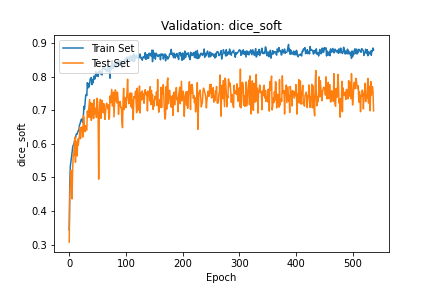

In [17]:
from IPython.display import Image
Image(filename = "evaluation/fold_0/validation.dice_soft.png")

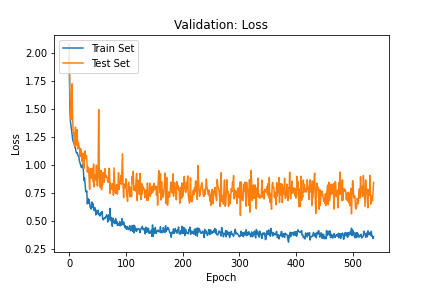

In [18]:
Image(filename = "evaluation/fold_0/validation.loss.png")

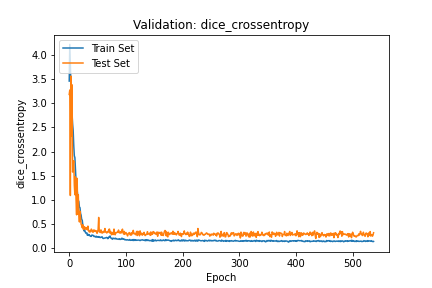

In [19]:
Image(filename = "evaluation/fold_0/validation.dice_crossentropy.png")

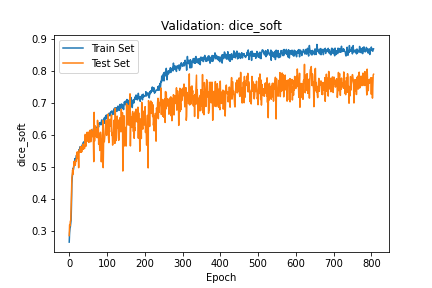

In [20]:
Image(filename = "evaluation/fold_1/validation.dice_soft.png")

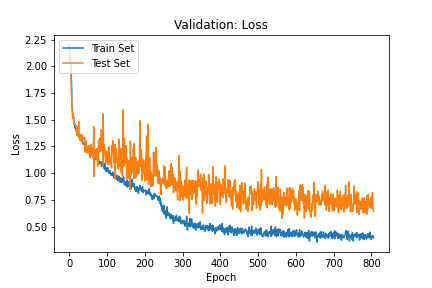

In [21]:
Image(filename = "evaluation/fold_1/validation.loss.png")

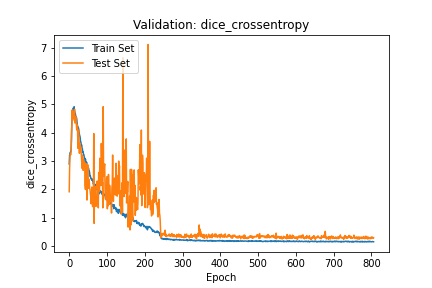

In [22]:
Image(filename = "evaluation/fold_1/validation.dice_crossentropy.png")

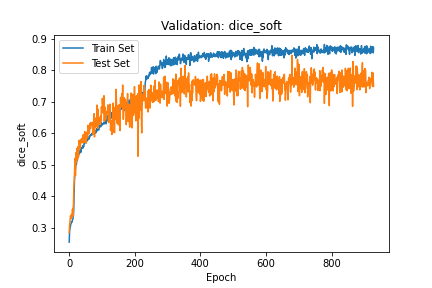

In [23]:
Image(filename = "evaluation/fold_2/validation.dice_soft.png")

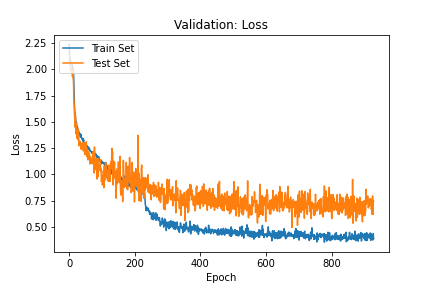

In [24]:
Image(filename = "evaluation/fold_2/validation.loss.png")

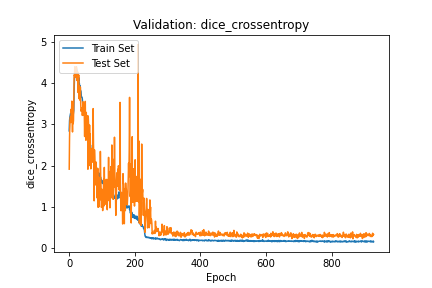

In [25]:
Image(filename = "evaluation/fold_2/validation.dice_crossentropy.png")

## Final words

Here, I presented the workflow of using MIScnn for medical image segmentation problems like in this example: The Kidney Tumor Segmentation Challenge 2019.  
I hope to give you an intention on how MIScnn works and how you can integrate/use MIScnn in your research projects.

For further questions or suggestions, please do not hesitate to get in contact with me.

Thanks for reading,  
Dominik Müller